In [134]:
#import modules
# https://www.datacamp.com/tutorial/discovering-hidden-topics-python
# tutorial: https://radimrehurek.com/gensim/auto_examples/howtos/run_compare_lda.html#sphx-glr-auto-examples-howtos-run-compare-lda-py

import nltk
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from urbandev.utils import load_data_csv, save_data
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
import gensim
import string
from gensim.models.coherencemodel import CoherenceModel
import jieba
from TCSP import read_stopwords_list
import pandas as pd

In [27]:
#download stopwords
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download("punkt")
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()



[nltk_data] Downloading package stopwords to /home/mojoee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mojoee/nltk_data...
[nltk_data] Downloading package punkt to /home/mojoee/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [28]:
df = load_data_csv('/home/mojoee/Research/11_UrbanDevelopment/03_UrbanDevelopmentTaiwan/data/translatedJoinProposals.csv')

In [29]:
df.columns

Index(['Index', 'publishDate', 'url', 'title', 'proposal', 'benefits&impact',
       '#Votes', 'MinVotesNecessary', 'SubmissionDate', 'Followers',
       'Messages', 'GA', 'proposer', 'proposalEN', 'titleEN', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21'],
      dtype='object')

In [30]:
# remove unnecessary columns
df.drop(['Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21'], axis = 1, inplace = True) 

In [31]:
df.head()

Index          publishDate  \
0      0  2015-09-10 13:26:19   
1      1  2015-09-10 16:08:10   
2      2  2015-09-10 19:40:31   
3      3  2015-09-10 20:45:11   
4      4  2015-09-10 21:40:32   

                                                 url  \
0  https://join.gov.tw/idea/detail/25824c17-f141-...   
1  https://join.gov.tw/idea/detail/75185e90-3a37-...   
2  https://join.gov.tw/idea/detail/4e658586-2a08-...   
3  https://join.gov.tw/idea/detail/94b5dca9-57fc-...   
4  https://join.gov.tw/idea/detail/3bdab9bf-d874-...   

                                        title  \
0                         Join 平台應提供匯出資料供批次下載   
1                  你是否贊成推動「十八歲投票權」及「二十歲被選舉權」?   
2  你是否贊成將國家撥給政黨的競選費用補助金門檻由3.5%降為3%，並設置10%的上限?   
3                                       都更的建議   
4                                        引進鞭刑   

                                            proposal  \
0  目前 Join 平台為方便機關人員作業，在後台有「打包匯出資料」的功能，但前台沒有開放給民眾...   
1  鑒於國民年滿十六歲即可工作、納稅，年滿十八歲就須負完全的刑事責任並有應考試、服公職的權利，卻...   
2  雖然之前國家撥給政黨的競選費用補助金門檻從5%下降至3.5%但仍不夠低，以國外案例來說德國為...   
3  國家既然採多數決.為何總是被少數人綁架.都更常因釘子戶造成困擾.個人建議.國家要發展.這個問...   
4               依先進國家如新加坡的刑法引進鞭刑讓重刑犯，強姦犯等重大罪犯得到應得的逞罰   

                                     benefits&impact #Votes MinVotesNecessary  \
0  這是 kiang 在 g0v 提出的想法。\n利益：提供民間備份，並可介接第三方進行全文檢索...     22               250   
1  世代正義是我國民主發展所必須正視的課題，\n若設置過高的年齡門檻形同將年輕世代排除在體制性的...      0                 0   
2  修法調降政黨競選費用補助金門檻有利於小黨發展並可促進多元政黨政治發展，\n稚現行修正後之門檻...      5               250   
3                                                NaN      2               250   
4         促進社會正義，讓正義得以伸張並幫助這些罪犯記取教訓以及促進受害者人權，進而讓國家進步    184               250   

        SubmissionDate Followers Messages GA proposer  \
0  2015-09-10 17:12:05         1        0  無       au   
1  2015-09-10 16:11:31         0        0  無     森里蛍一   
2  2015-09-22 00:45:06         1        3  無     森里蛍一   
3  2015-09-10 20:49:17         0        0  無      樂與喜   
4  2015-09-10 21:42:48         4        0  無      UFO   

                                          proposalEN  \
0  At present, the Join platform has the function...   
1  In view of the fact that citizens can work and...   
2  Although the national subsidy threshold for po...   
3  Since the country adopts a majority vote, why ...   
4  According to the criminal law of advanced coun...   

                                             titleEN  
0  The Join platform should provide export data f...  
1  Do you agree to promote "the right to vote at ...  
2  Do you favor reducing the threshold for state ...  
3                               All more suggestions  
4                                   Introduce caning

In [32]:
def reshapeData(df):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    #drop zeros
    df= df.dropna()
    df= df[df['proposalEN'] != 0]
    documents_list = [document.lower() for document in df["titleEN"].to_list()]
    #documents_list = [document.lower() for document in documents_list]
    titles = [title.lower() for title in df["titleEN"].to_list()]
    #titles = [title.lower() for title in titles]
    print("Total Number of Documents:", len(df.index))
    return documents_list, titles

In [33]:
def preprocess_data(doc_set):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts


In [34]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix


In [35]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel


In [40]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = models.LdaMulticore(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=20, random_state=42, chunksize=2000,
                                alpha='symmetric', eta=None, decay=0.5, offset=1.0, eval_every=10, iterations=1)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Total Number of Documents: 13991


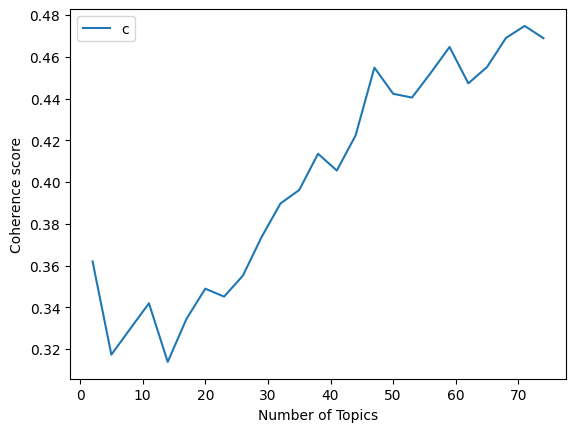

In [44]:
def plot_graph(doc_clean,start, stop, step):
    dictionary, doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

document_list, titles = reshapeData(df)
clean_text = preprocess_data(document_list)
start,stop,step=2,25,1
plot_graph(clean_text,start,stop,step)

In [42]:
# LSA Model 
number_of_topics=7
words=20
model=create_gensim_lsa_model(clean_text,number_of_topics,words)


[(0, '0.492*"worker" + 0.464*"foreign" + 0.269*"employ" + 0.230*"taiwan" + 0.124*"contact" + 0.123*"care" + 0.115*"work" + 0.113*"school" + 0.111*"escap" + 0.102*"must" + 0.100*"govern" + 0.097*"famili" + 0.095*"student" + 0.090*"report" + 0.089*"protect" + 0.087*"illeg" + 0.085*"law" + 0.085*"system" + 0.084*"appli" + 0.084*"lose"'), (1, '0.341*"school" + 0.282*"student" + -0.271*"worker" + 0.222*"govern" + -0.222*"foreign" + 0.222*"loan" + 0.203*"orphan" + 0.202*"peopl" + 0.200*"taiwan" + 0.153*"disadvantag" + 0.152*"guarantor" + -0.146*"employ" + 0.145*"past" + 0.137*"rel" + 0.132*"educ" + 0.124*"fee" + 0.107*"rule" + 0.103*"tuition" + 0.095*"also" + 0.093*"studi"'), (2, '0.303*"public" + 0.188*"high" + 0.180*"nation" + 0.165*"year" + 0.153*"law" + 0.151*"time" + -0.150*"loan" + 0.147*"health" + -0.138*"orphan" + 0.134*"school" + 0.124*"earthquak" + -0.123*"foreign" + -0.118*"worker" + 0.113*"implement" + 0.112*"prevent" + -0.104*"guarantor" + -0.103*"disadvantag" + 0.102*"ministri"

In [43]:
model.print_topics()

[(0,
  '0.492*"worker" + 0.464*"foreign" + 0.269*"employ" + 0.230*"taiwan" + 0.124*"contact" + 0.123*"care" + 0.115*"work" + 0.113*"school" + 0.111*"escap" + 0.102*"must"'),
 (1,
  '0.341*"school" + 0.282*"student" + -0.271*"worker" + 0.222*"govern" + -0.222*"foreign" + 0.222*"loan" + 0.203*"orphan" + 0.202*"peopl" + 0.200*"taiwan" + 0.153*"disadvantag"'),
 (2,
  '0.303*"public" + 0.188*"high" + 0.180*"nation" + 0.165*"year" + 0.153*"law" + 0.151*"time" + -0.150*"loan" + 0.147*"health" + -0.138*"orphan" + 0.134*"school"'),
 (3,
  '0.691*"school" + 0.374*"high" + -0.224*"taiwan" + -0.180*"govern" + -0.161*"peopl" + 0.132*"student" + 0.114*"class" + -0.098*"languag" + -0.098*"china" + -0.088*"cultur"'),
 (4,
  '0.561*"earthquak" + 0.293*"broadcast" + 0.257*"report" + 0.204*"quick" + 0.195*"inform" + -0.177*"nation" + 0.165*"time" + 0.155*"public" + -0.143*"languag" + 0.138*"channel"'),
 (5,
  '0.320*"taiwan" + -0.265*"health" + 0.251*"nation" + 0.246*"china" + 0.223*"languag" + 0.185*"cu

In [46]:
stopwords.

<WordListCorpusReader in '/home/mojoee/nltk_data/corpora/stopwords'>

In [54]:
# LDA

# maybe add some more stopwords
# stopwords+=["\"","/","=",":","-",".","false",">",";","https", "~", "1", "2", "3", "4", "5", "6", 
#              "7", "8", "9", "<", "w", "Priority","LsdException","Locked","SemiHidden","Name", "UnhideWhenUsed",
#              "--","Accent", "!", "?", "+", "mso", "0", "*", "]", "[", "The", "'", '000']


# Tokenize the documents using jieba
tokenized_documents = preprocess_data(document_list)

# tokenized_documents = [preprocess_data(doc) for doc in document_list]

# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_documents)

# Create a bag of words corpus from the tokenized documents
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Train an LDA model
# need to finetune some of the params
num_topics = 7
lda_model = models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=20, random_state=42, chunksize=2000,
                                alpha='symmetric', eta=None, decay=0.5, offset=1.0, eval_every=10, iterations=1)

# Display the topics
for i in range(num_topics):
    print(f"Topic {i+1}: {lda_model.print_topic(i)}")


Topic 1: 0.012*"peopl" + 0.011*"nation" + 0.007*"law" + 0.007*"public" + 0.006*"taiwan" + 0.005*"labor" + 0.005*"ministri" + 0.005*"govern" + 0.005*"health" + 0.005*"insur"
Topic 2: 0.010*"govern" + 0.009*"taiwan" + 0.007*"law" + 0.007*"improv" + 0.006*"countri" + 0.005*"public" + 0.005*"use" + 0.004*"amend" + 0.004*"abolish" + 0.004*"regul"
Topic 3: 0.020*"school" + 0.017*"drive" + 0.014*"law" + 0.013*"penalti" + 0.012*"drunk" + 0.009*"high" + 0.009*"death" + 0.008*"increas" + 0.007*"student" + 0.006*"amend"
Topic 4: 0.010*"light" + 0.010*"traffic" + 0.009*"road" + 0.008*"licens" + 0.008*"tax" + 0.007*"use" + 0.007*"nation" + 0.006*"public" + 0.006*"chang" + 0.006*"vehicl"
Topic 5: 0.012*"nation" + 0.012*"taiwan" + 0.007*"vehicl" + 0.007*"public" + 0.007*"china" + 0.006*"time" + 0.006*"year" + 0.006*"school" + 0.005*"countri" + 0.005*"govern"
Topic 6: 0.013*"taiwan" + 0.012*"public" + 0.008*"govern" + 0.007*"peopl" + 0.007*"nation" + 0.006*"system" + 0.005*"servic" + 0.005*"educ" + 0.

In [ ]:
# ID IFD --> not necessary for LDA, because it's already a probabilistic model

In [49]:
def concatenate_topic(topic):
    output=[]
    for i in range(len(topic)):
        output.append(topic[i][0])
    return output

In [50]:
concatenate_topic(lda_model.show_topic(3))

['traffic',
 'light',
 'licens',
 'road',
 'tax',
 'use',
 'nation',
 'right',
 'vehicl',
 'public']

In [20]:
# topics identified for n=5
# 0 education
# 1 labor law and government
# 2 school & students
# 3 driving & vehicles
# 4 crime (also drunk driving)

In [ ]:
# topics identified for n=8
# 0 education & school
# 1 labor law and government
# 2 school & health system
# 3 driving & vehicles
# 4 crime (also drunk driving)

In [21]:
# topics identified for n=10
# 0 crime
# 1 water, food, power --> basic needs
# 2 medical, insurance, military
# 3 error with chinese
# 4 Traffic and urban development
# 5 animals and pets
# 6 government and china politics
# 7 tax and salary
# 8 education
# 9 error with chinese

In [22]:
recognized_topics_5 = {0: "education", 1: "labor", 2: "school", 3: "vehicles", 4: "crime"}

In [86]:
recognized_topics = {0: "crime", 1: "basicNeeds", 2: "medical", 3: "errorChin", 4:"Traffic&Cars", 5:"animals&pets", 6: "government&china", 7:"tax&salary",
                     8: "education", 9: "errorChin"}

In [55]:
for i in range(num_topics):
    print(concatenate_topic(lda_model.show_topic(i)))

['peopl', 'nation', 'law', 'public', 'taiwan', 'labor', 'ministri', 'govern', 'health', 'insur']
['govern', 'taiwan', 'law', 'improv', 'countri', 'public', 'use', 'amend', 'abolish', 'regul']
['school', 'drive', 'law', 'penalti', 'drunk', 'high', 'death', 'increas', 'student', 'amend']
['light', 'traffic', 'road', 'licens', 'tax', 'use', 'nation', 'public', 'chang', 'vehicl']
['nation', 'taiwan', 'vehicl', 'public', 'china', 'time', 'year', 'school', 'countri', 'govern']
['taiwan', 'public', 'govern', 'peopl', 'nation', 'system', 'servic', 'educ', 'pleas', 'law']
['school', 'high', 'educ', 'class', 'student', 'taiwan', 'chang', 'use', 'system', 'reduc']


In [57]:
recognized_topics_7 = {0: "public system", 1: "law", 2: "school", 3: "traffic and roads and taxes", 4: "vehicle, china", 5: "system", 6: "education"}

In [58]:
# Now how can I label the proposals ?

In [59]:
# visualize 

def plot_difference_plotly(mdiff, title="", annotation=None):
    """Plot the difference between models.

    Uses plotly as the backend."""
    import plotly.graph_objs as go
    import plotly.offline as py

    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                for (int_tokens, diff_tokens) in row
            ]
            for row in annotation
        ]

    data = go.Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = go.Layout(width=950, height=950, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))


def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)


try:
    get_ipython()
    import plotly.offline as py
except Exception:
    #
    # Fall back to matplotlib if we're not in a notebook, or if plotly is
    # unavailable for whatever reason.
    #
    plot_difference = plot_difference_matplotlib
else:
    py.init_notebook_mode()
    plot_difference = plot_difference_plotly

In [60]:
print(models.LdaModel.__doc__)


Train and use Online Latent Dirichlet Allocation model as presented in
    `'Online Learning for LDA' by Hoffman et al.`_

    Examples
    -------
    Initialize a model using a Gensim corpus

    .. sourcecode:: pycon

        >>> from gensim.test.utils import common_corpus
        >>>
        >>> lda = LdaModel(common_corpus, num_topics=10)

    You can then infer topic distributions on new, unseen documents.

    .. sourcecode:: pycon

        >>> doc_bow = [(1, 0.3), (2, 0.1), (0, 0.09)]
        >>> doc_lda = lda[doc_bow]

    The model can be updated (trained) with new documents.

    .. sourcecode:: pycon

        >>> # In practice (corpus =/= initial training corpus), but we use the same here for simplicity.
        >>> other_corpus = common_corpus
        >>>
        >>> lda.update(other_corpus)

    Model persistency is achieved through :meth:`~gensim.models.ldamodel.LdaModel.load` and
    :meth:`~gensim.models.ldamodel.LdaModel.save` methods.

    


In [61]:
print(models.LdaModel.diff.__doc__)

Calculate the difference in topic distributions between two models: `self` and `other`.

        Parameters
        ----------
        other : :class:`~gensim.models.ldamodel.LdaModel`
            The model which will be compared against the current object.
        distance : {'kullback_leibler', 'hellinger', 'jaccard', 'jensen_shannon'}
            The distance metric to calculate the difference with.
        num_words : int, optional
            The number of most relevant words used if `distance == 'jaccard'`. Also used for annotating topics.
        n_ann_terms : int, optional
            Max number of words in intersection/symmetric difference between topics. Used for annotation.
        diagonal : bool, optional
            Whether we need the difference between identical topics (the diagonal of the difference matrix).
        annotation : bool, optional
            Whether the intersection or difference of words between two topics should be returned.
        normed : bool, optio

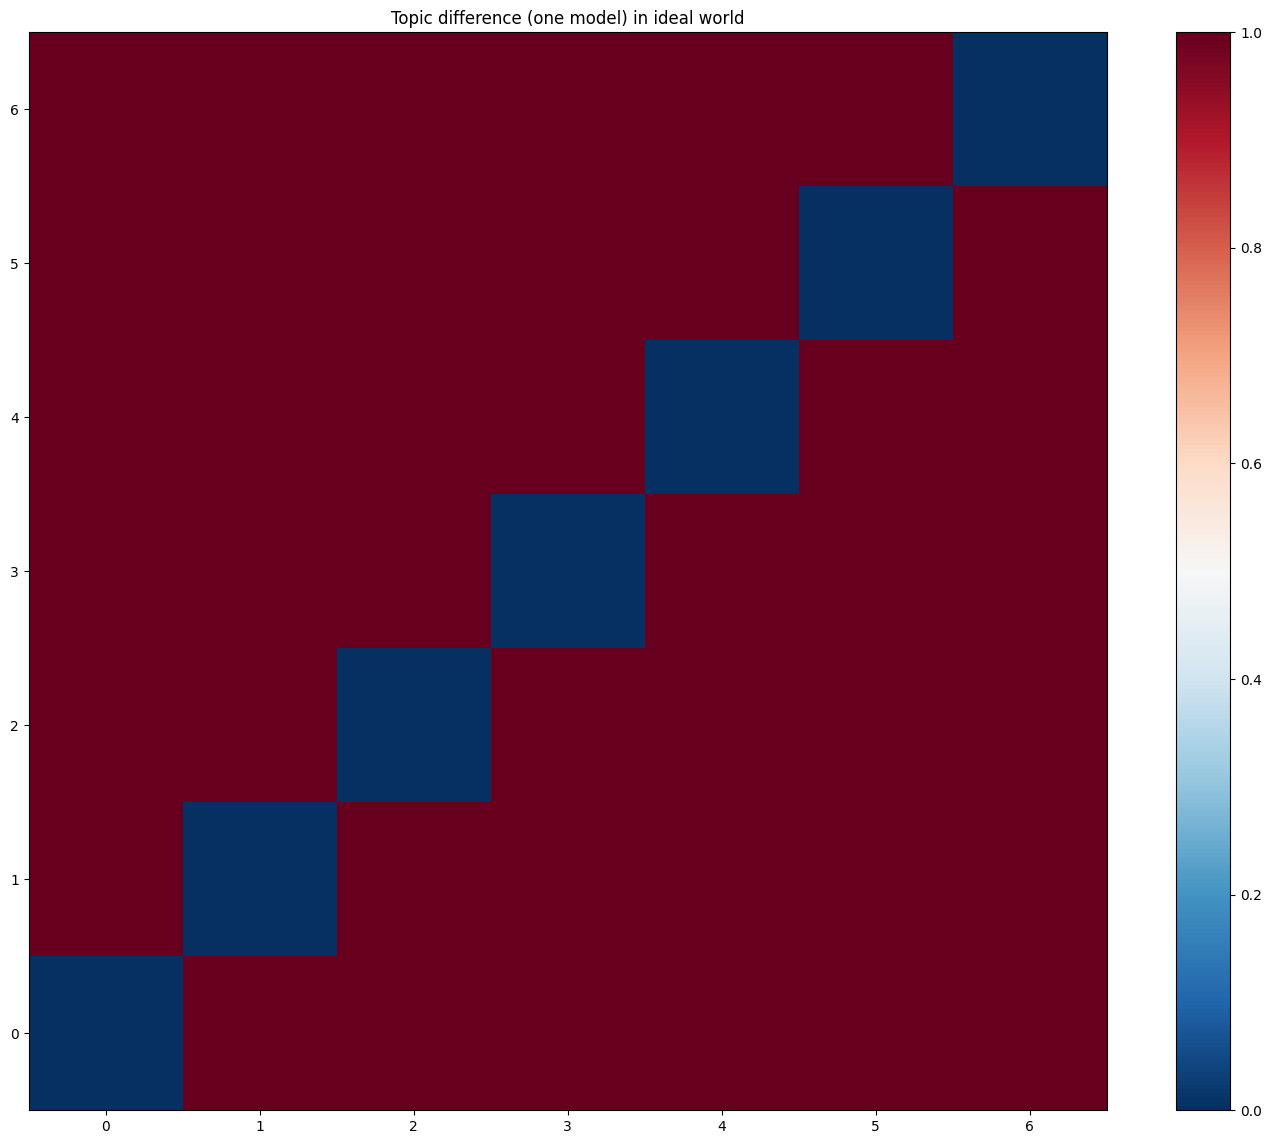

In [62]:
import numpy as np

mdiff = np.ones((num_topics, num_topics))
np.fill_diagonal(mdiff, 0.)
plot_difference(mdiff, title="Topic difference (one model) in ideal world")

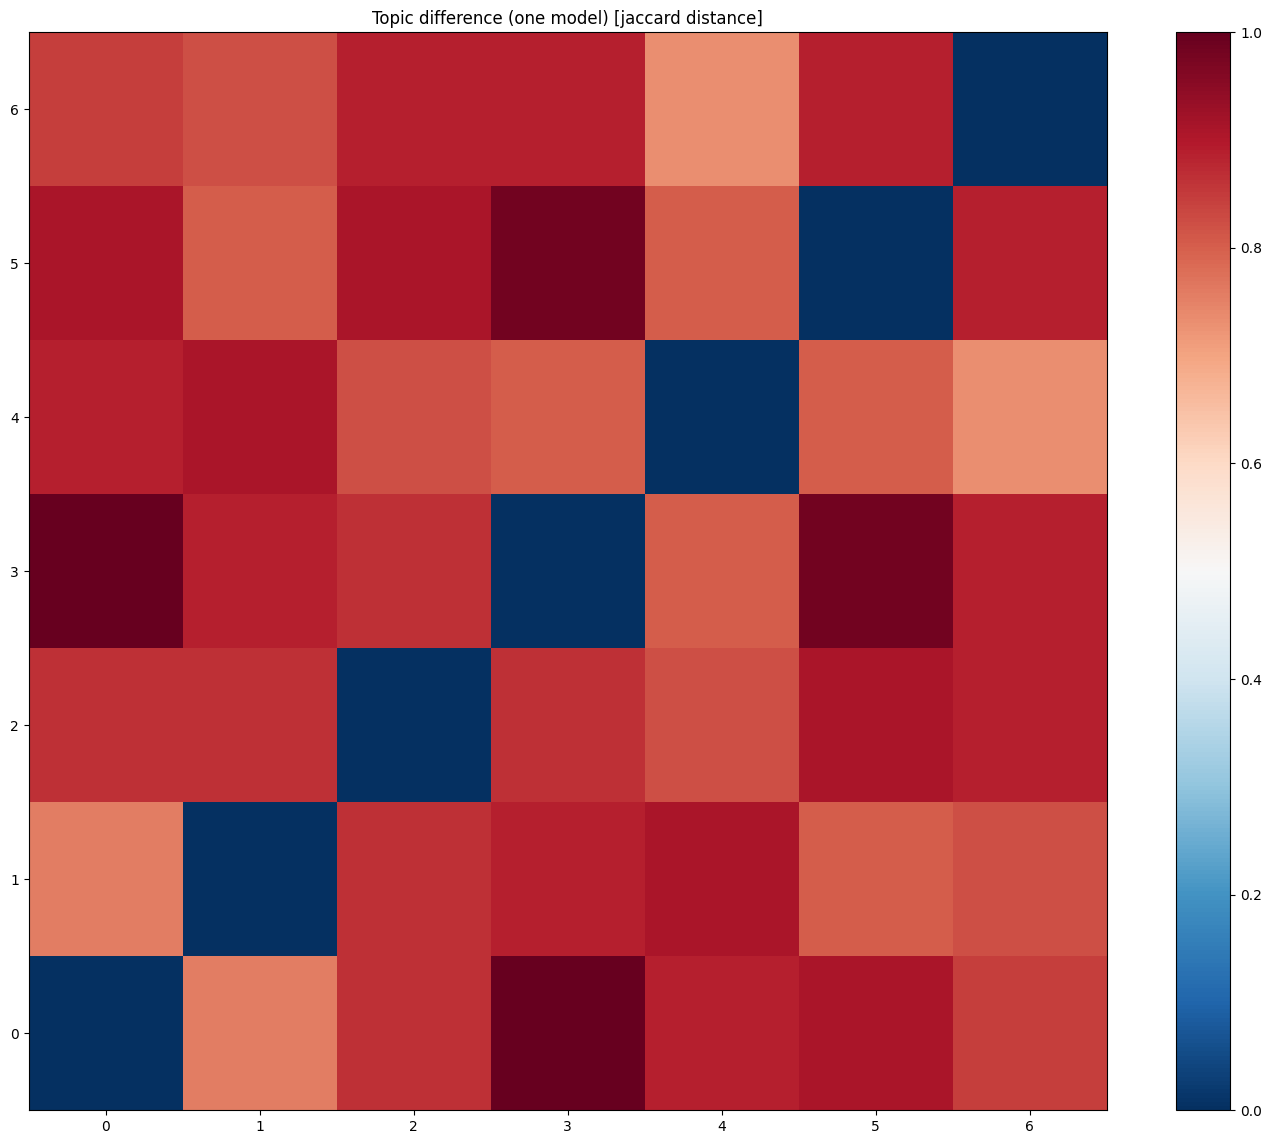

In [63]:
mdiff, annotation = lda_model.diff(lda_model, distance='jaccard', num_words=50)
plot_difference(mdiff, title="Topic difference (one model) [jaccard distance]", annotation=annotation)

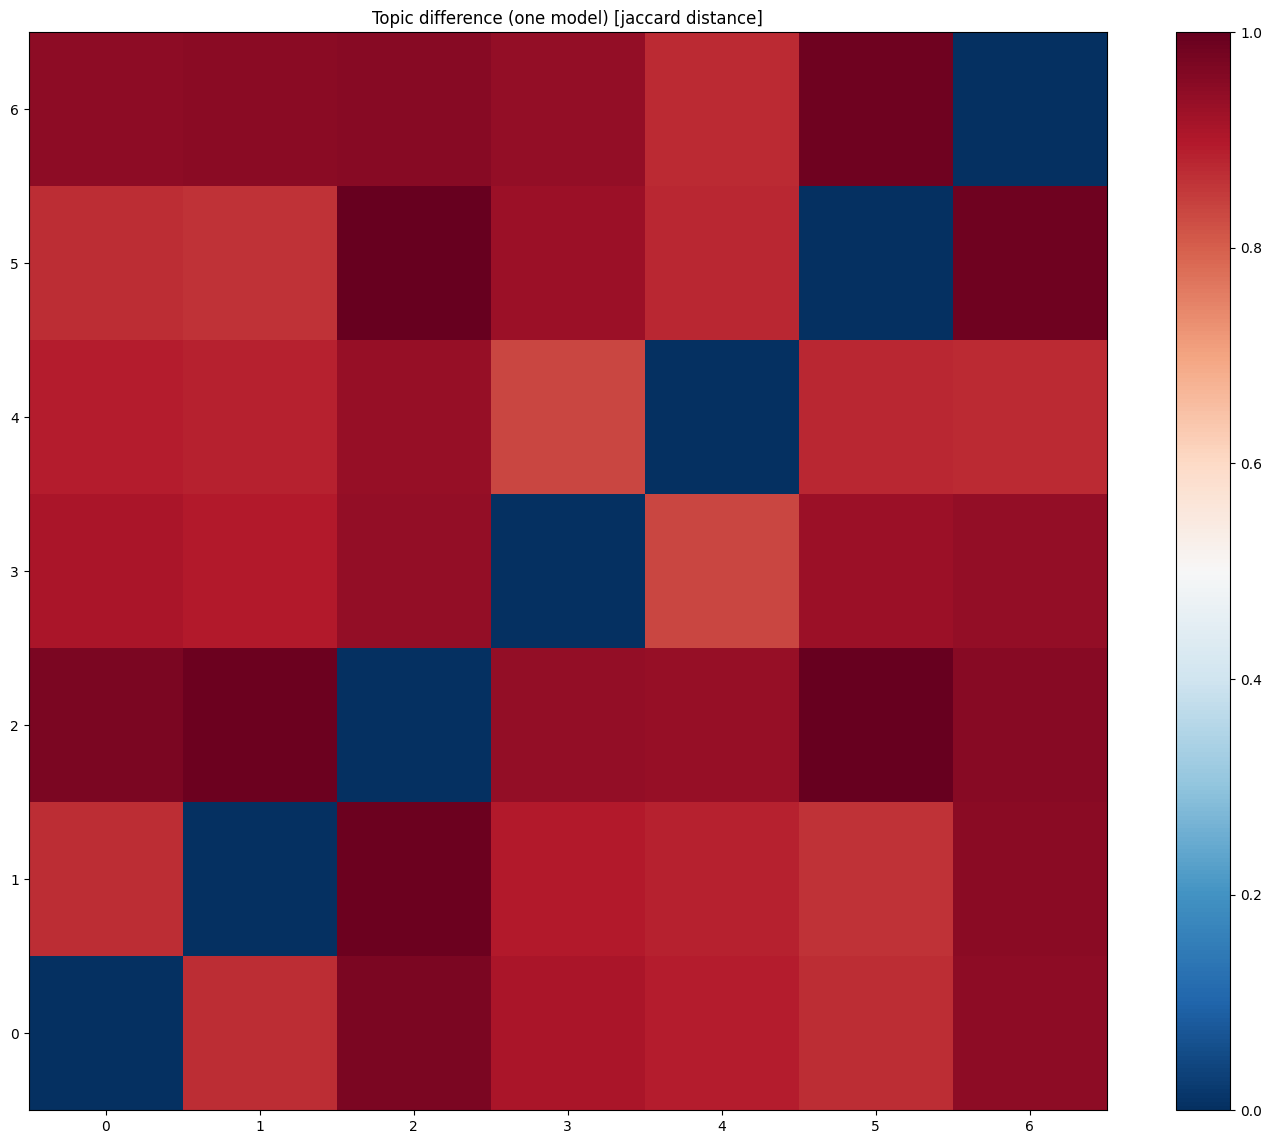

In [64]:
mdiff, annotation = lda_model.diff(lda_model, distance='hellinger', num_words=50)
plot_difference(mdiff, title="Topic difference (one model) [jaccard distance]", annotation=annotation)

In [65]:
# label the df 
lda_model.get_document_topics()

TypeError: LdaModel.get_document_topics() missing 1 required positional argument: 'bow'

In [66]:
labels, _ = lda_model.inference(corpus)
topic_numbers = np.argmax(labels, axis=1)

In [67]:
labels[0]

array([1.3187692 , 1.1006471 , 1.0633086 , 0.93375075, 0.5793274 ,
       2.3988767 , 0.5792939 ], dtype=float32)

In [68]:
multipleLabels = np.argpartition(labels, -3, axis=1)

In [69]:
multipleLabels[:, -1]

array([0, 6, 6, ..., 2, 0, 6])

In [70]:
df=df.dropna()
df['Topic1'] = multipleLabels[:, -1].tolist()
df['Topic2'] = multipleLabels[:, -2].tolist()
df['Topic3'] = multipleLabels[:, -3].tolist()

In [71]:
df.iloc[8]  


Index                                                                9
publishDate                                        2015-09-12 02:23:57
url                  https://join.gov.tw/idea/detail/87354c05-f36e-...
title                              敬請具體實踐中華民國憲法第143條：中華民國領土內之土地屬於國民全體。
proposal             中華民國公有土地，兩則相關條文內容如下：中華民國憲法第143條：中華民國領土內之土地屬於國民...
benefits&impact      建構「國民全體參與公有土地決策機制」之利益影響列舉如下：\n \n\n具體落實中華民國憲法第...
#Votes                                                              52
MinVotesNecessary                                                  250
SubmissionDate                                     2015-09-12 02:26:16
Followers                                                            2
Messages                                                             0
GA                                                                   無
proposer                                                   Che Wei Liu
proposalEN           The contents of the two related articles are a...
titleE

In [72]:
# need to adjust the topics here
topicLegend=recognized_topics_5
df["category1"] = df["Topic1"].apply(lambda x: topicLegend[x])
df["category2"] = df["Topic2"].apply(lambda x: topicLegend[x])
df["category3"] = df["Topic3"].apply(lambda x: topicLegend[x])

In [73]:
# how many proposals for each topic
df.groupby(['Topic2']).count()

Index  publishDate   url  title  proposal  benefits&impact  #Votes  \
Topic2                                                                       
0        1342         1342  1342   1342      1342             1342    1342   
1        2410         2410  2410   2410      2410             2410    2410   
2        2252         2252  2252   2252      2252             2252    2252   
3        1335         1335  1335   1335      1335             1335    1335   
4        2245         2245  2245   2245      2245             2245    2245   
5        3179         3179  3179   3179      3179             3179    3179   
6        1228         1228  1228   1228      1228             1228    1228   

        MinVotesNecessary  SubmissionDate  Followers  Messages    GA  \
Topic2                                                                 
0                    1342            1342       1342      1342  1342   
1                    2410            2410       2410      2410  2410   
2                    2252            2252       2252      2252  2252   
3                    1335            1335       1335      1335  1335   
4                    2245            2245       2245      2245  2245   
5                    3179            3179       3179      3179  3179   
6                    1228            1228       1228      1228  1228   

        proposer  proposalEN  titleEN  Topic1  Topic3  category1  category2  \
Topic2                                                                        
0           1342        1342     1342    1342    1342       1342       1342   
1           2410        2410     2410    2410    2410       2410       2410   
2           2252        2252     2252    2252    2252       2252       2252   
3           1335        1335     1335    1335    1335       1335       1335   
4           2245        2245     2245    2245    2245       2245       2245   
5           3179        3179     3179    3179    3179       3179       3179   
6           1228        1228     1228    1228    1228       1228       1228   

        category3  
Topic2             
0            1342  
1            2410  
2            2252  
3            1335  
4            2245  
5            3179  
6            1228

<Axes: xlabel='Topic1'>

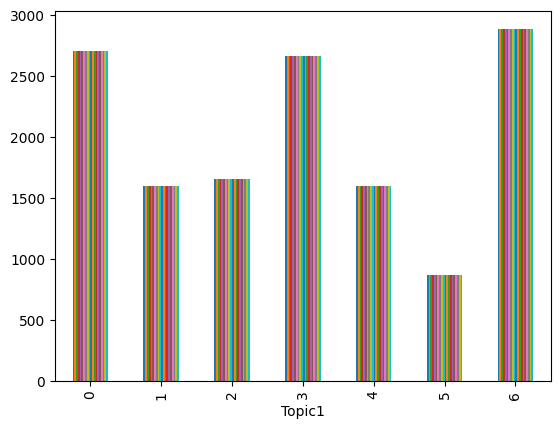

In [95]:
df.groupby(['Topic1']).count().plot(kind='bar', legend=False,)

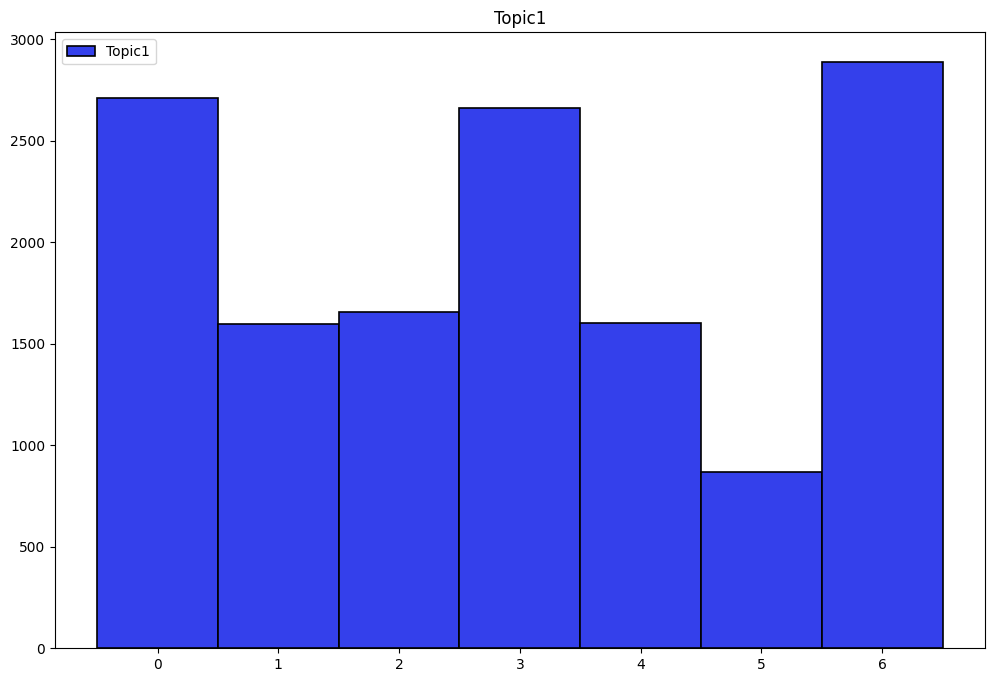

In [96]:
ax = df.hist(column='Topic1', bins=range(8),
grid=False, figsize=(12,8), color='#3440eb', legend=True, edgecolor='black', linewidth=1.2, align='left')

In [97]:
recognized_topics_7

{0: 'public system',
 1: 'law',
 2: 'school',
 3: 'traffic and roads and taxes',
 4: 'vehicle, china',
 5: 'system',
 6: 'education'}

In [98]:
df.columns

Index(['Index', 'publishDate', 'url', 'title', 'proposal', 'benefits&impact',
       '#Votes', 'MinVotesNecessary', 'SubmissionDate', 'Followers',
       'Messages', 'GA', 'proposer', 'proposalEN', 'titleEN', 'Topic1',
       'Topic2', 'Topic3', 'category1', 'category2', 'category3'],
      dtype='object')

In [127]:
# need to clean the data better, since there is some issues with data jumping into the wrong column
for index, row in df.iterrows():
    if not str(row["#Votes"]).isnumeric():
        print(index)
        df.at[index,'#Votes']=0
    if not str(row["MinVotesNecessary"]).isnumeric():
        df.at[index, "MinVotesNecessary"]=5000
        print(index)

In [123]:
df.iloc[100]

Index                                                              139
publishDate                                        2016-06-15 19:40:38
url                  https://join.gov.tw/idea/detail/79d35ea8-455e-...
title                         如何讓南部地區太陽能發電，加速屋頂太陽能發電，使老百姓願意投資並提早完成非核家園
proposal             因政府財政困難，又要找地還要花錢建置並維護，現行太陽能屋頂發電尤以台南申請件數最多，如果使用...
benefits&impact      利益，老百姓可以從發電賺到錢，政府可以省下找地及建置(含維護費用)，當然如能時進行更佳，不過...
#Votes                                                               5
MinVotesNecessary                                                  250
SubmissionDate                                     2016-06-15 19:42:19
Followers                                                            1
Messages                                                             0
GA                                                                   無
proposer                                                          蓋故 動
proposalEN           Due to the government’s financial difficulties...
titleE

In [135]:
df["MinVotesNecessary"] = pd.to_numeric(df["MinVotesNecessary"])
df["#Votes"] = pd.to_numeric(df["#Votes"])

In [136]:
df.dtypes

Index                 int64
publishDate          object
url                  object
title                object
proposal             object
benefits&impact      object
#Votes                int64
MinVotesNecessary     int64
SubmissionDate       object
Followers            object
Messages             object
GA                   object
proposer             object
proposalEN           object
titleEN              object
Topic1                int64
Topic2                int64
Topic3                int64
category1            object
category2            object
category3            object
dtype: object

In [137]:
# passed votes
PassedProposalsTraffic = df.loc[(df['category1'].isin([recognized_topics_7[3], recognized_topics_7[4]])) & (df["#Votes"]>df['MinVotesNecessary'])]

In [138]:
PassedProposalsTraffic

Index          publishDate  \
98        98  2016-04-21 22:38:32   
105      105  2016-05-05 20:45:48   
175      175  2016-07-12 17:46:45   
276      276  2016-09-08 01:17:52   
281      281  2016-09-08 15:12:41   
...      ...                  ...   
11807  11807  2021-06-09 03:00:43   
12207  12207  2021-08-04 12:20:06   
12551  12551  2021-09-22 08:25:04   
13053  13053  2021-11-08 20:51:00   
13100  13100  2021-11-17 12:23:28   

                                                     url  \
98     https://join.gov.tw/idea/detail/985c9388-59f0-...   
105    https://join.gov.tw/idea/detail/b2205964-f157-...   
175    https://join.gov.tw/idea/detail/2f05760d-5202-...   
276    https://join.gov.tw/idea/detail/5be40d90-0f96-...   
281    https://join.gov.tw/idea/detail/cbba45db-4b5b-...   
...                                                  ...   
11807  https://join.gov.tw/idea/detail/b74fffa1-f4f9-...   
12207  https://join.gov.tw/idea/detail/285f0a1c-eaf3-...   
12551  https://join.gov.tw/idea/detail/356046f2-6b03-...   
13053  https://join.gov.tw/idea/detail/31002fed-1b21-...   
13100  https://join.gov.tw/idea/detail/79336469-98e7-...   

                                                   title  \
98                                     執行「車速分流」，取消「車種分流」   
105                                              機車改裝合法化   
175                                        月亮杯比照衛生棉條合法網購   
276                                          汽機車燃料稅應隨油徵收   
281                                              推動安樂死合法   
...                                                  ...   
11807                                立法修改醫護人員應強制加入工會而非公會   
12207  嚴懲五萬名逃逸外勞，縮短逃逸造成的照護空窗期，將家庭看護納入衛福部，保障失能、失智者的受照護...   
12551                      防疫期間，請停止對海外國人「出境超過2年，遷出戶籍」限制！   
13053             請交通部開設「交通疫情指揮中心」 舉辦記者會 詳報交通傷亡數字原因並接受提問   
13100                          拯救台灣特有罕病FAP，呼籲加速FAP罕藥健保給付   

                                                proposal  \
98     當時代與科技不斷的在進步時，法律和制度必須同時盡快跟上，才能確保人民的權益。前提：行駛在道路...   
105    嘉義一位騎士花了七萬多元改裝費將愛車的後輪改寬.軸距改長.犯了天條.被警方查扣後.開了五張罰...   
175    　　月事用品在台灣的販售推廣向來有諸多限制，因被歐盟歸類為民生用品的衛生棉條（tampon）...   
276    汽機車燃料稅，目前是以車子的引擎排放量為基準，作為費率標準，這完全是一個莫名其妙的制度顧名思...   
281     明天會更好？尊嚴的走吧!—安樂死合法化 「輕輕敲醒沉睡的心靈，慢慢張開你的眼睛，…明天會更...   
...                                                  ...   
11807                       公會是立屬於學術團體故應是依各人意願加入，而不應強制加入   
12207  本案提議重點在於保障「失能者家庭」的「失能」、「失智」病人，合法聘僱家庭看護工卻沒有獲得保障...   
12551  我是旅居日本已經30年以上的台灣國民（唯一的國籍是台灣）。生活的重心雖然在日本，但是每年都會...   
13053  立院交通委員會限縮檢舉樣態之後毫無配套措施，非解決問題而解決「提出問題的人」。目前我國每年超...   
13100  「家族性澱粉樣多發性神經病變」（FAP）為罕見遺傳疾病，以男性居多，平均在50歲發病，此時，...   

                                         benefits&impact  #Votes  \
98     個人對道路的定義是，能從Ａ點快速到達Ｂ點如此而已，車速分流的重要就是舒緩交通壅塞，不是右轉車...    5079   
105    嘉義一位騎士花了七萬多元改裝費將愛車的後輪改寬.軸距改長.犯了天條.被警方查扣後.開了五張罰...    6010   
175    　　降低民眾取得L.5400醫療器材的門檻，得以增加其他廠商進口L.5400的意願，讓有心耕...    6150   
276    帶來的利益：\n\n回歸使用者（污染者）付費，有效減少空氣污染與碳排放：台灣目前的人均碳排放...    5962   
281                                 減少無效醫療，減輕健保負擔，節省社會成本    5392   
...                                                  ...     ...   
11807  公會是立屬於學術團體故應是依各人意願加入，而不應強制加入，且醫護人員於醫療院所是屬於僱傭條件...    5194   
12207  我國對外籍勞工的保障，已經限制住雇主許多權益。但無限上綱保障外籍勞工，會使得他們隨時可以逃逸...    5238   
12551  基於出境超過2年會被遷出戶籍以及選罷法對於地方性選舉必需在當地設籍6個月以上的規定，可能造成...    5026   
13053  利益： \n  \n小朋友可以自己上學不用開車載，不用因為害怕危險交通而不敢走路上學、不敢搭...    5572   
13100  一、「家族性澱粉樣多發性神經病變」病友能在藥物治療下，以延緩疾病惡化速度，繼續在職場工作。降...    5492   

       MinVotesNecessary       SubmissionDate Followers  ... GA  \
98                  5000  2016-04-21 22:41:43       642  ...  無   
105                 5000  2016-05-05 20:46:09      1022  ...  無   
175                 5000  2016-07-12 17:58:39       461  ...  無   
276                 5000  2016-09-08 15:00:41       579  ...  無   
281                 5000  2016-09-08 15:13:08       538  ...  無   
...                  ...                  ...       ...  ... ..   
11807               5000  2021-06-09 03:01:10       183  ...  無   
12207               5000  2021-08-04 12:20:30 

In [139]:
save_data(PassedProposalsTraffic, "./results/PassedProposalsTrafficSecondTry.csv")

In [142]:
# evaluation with coherence model
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass') # measures : {'u_mass', 'c_v', 'c_uci', 'c_npmi'}
coherence = cm.get_coherence()  # get coherence value
print(f"The u_mass for the current model is {coherence}")

# to compare two coherence models 
# cm = CoherenceModel.for_models([m1, m2], common_dictionary, corpus=common_corpus, coherence='u_mass')


The coherence for the current model is -3.5970514253363377


In [152]:
# fix the 
cm = CoherenceModel(model=lda_model, dictionary=dictionary, texts=corpus, coherence='c_v')
print(f"the coherence of the topics is {cm.get_coherence()}")

the coherence of the topics is nan


In [146]:
# implement the nice visualization with terms and intertopic distance
# implement the word cloud for the given topics
# tune this notebook with a few more tricks from the source

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.052154 -0.014237       1        1  14.391587
0      0.031363 -0.011201       2        1  14.315476
1      0.038970  0.001403       3        1  14.299374
4     -0.006031  0.021926       4        1  14.265120
2     -0.065659 -0.058719       5        1  14.264048
6     -0.044265  0.060601       6        1  14.244958
3     -0.006532  0.000227       7        1  14.219437, topic_info=        Term         Freq        Total Category  logprob  loglift
173   school  1386.000000  1386.000000  Default  30.0000  30.0000
164    drive   578.000000   578.000000  Default  29.0000  29.0000
301     high   794.000000   794.000000  Default  28.0000  28.0000
539    drunk   333.000000   333.000000  Default  27.0000  27.0000
167  penalti   420.000000   420.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
164    drive    78.332672   578.980657   Topic7  -5.5656  -0.0497
129    peopl    78.465081   773.890451   Topic7  -5.5639  -0.3382
174   taiwan    77.714841  1128.892101   Topic7  -5.5736  -0.7254
97   prevent    66.245393   376.252450   Topic7  -5.7332   0.2137
173   school    74.119240  1386.292797   Topic7  -5.6209  -0.9782

[635 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2614      1  0.035015          00
2614      2  0.035015          00
2614      3  0.105045          00
2614      4  0.186746          00
2614      5  0.175075          00
...     ...       ...         ...
2305      3  0.139741      yunlin
3885      2  0.786664  zhongzheng
764       6  0.864480      zhubei
5252      3  0.838807      zhuwei
3623      6  0.880492           無

[1922 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 2, 5, 3, 7, 4])

In [167]:
wordcloudpreprocess = [" ".join(doc) for doc in tokenized_documents]

In [175]:
wordcloudinput = ' '.join(wordcloudpreprocess)

/home/mojoee/Research/11_UrbanDevelopment/03_UrbanDevelopmentTaiwan/.venv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


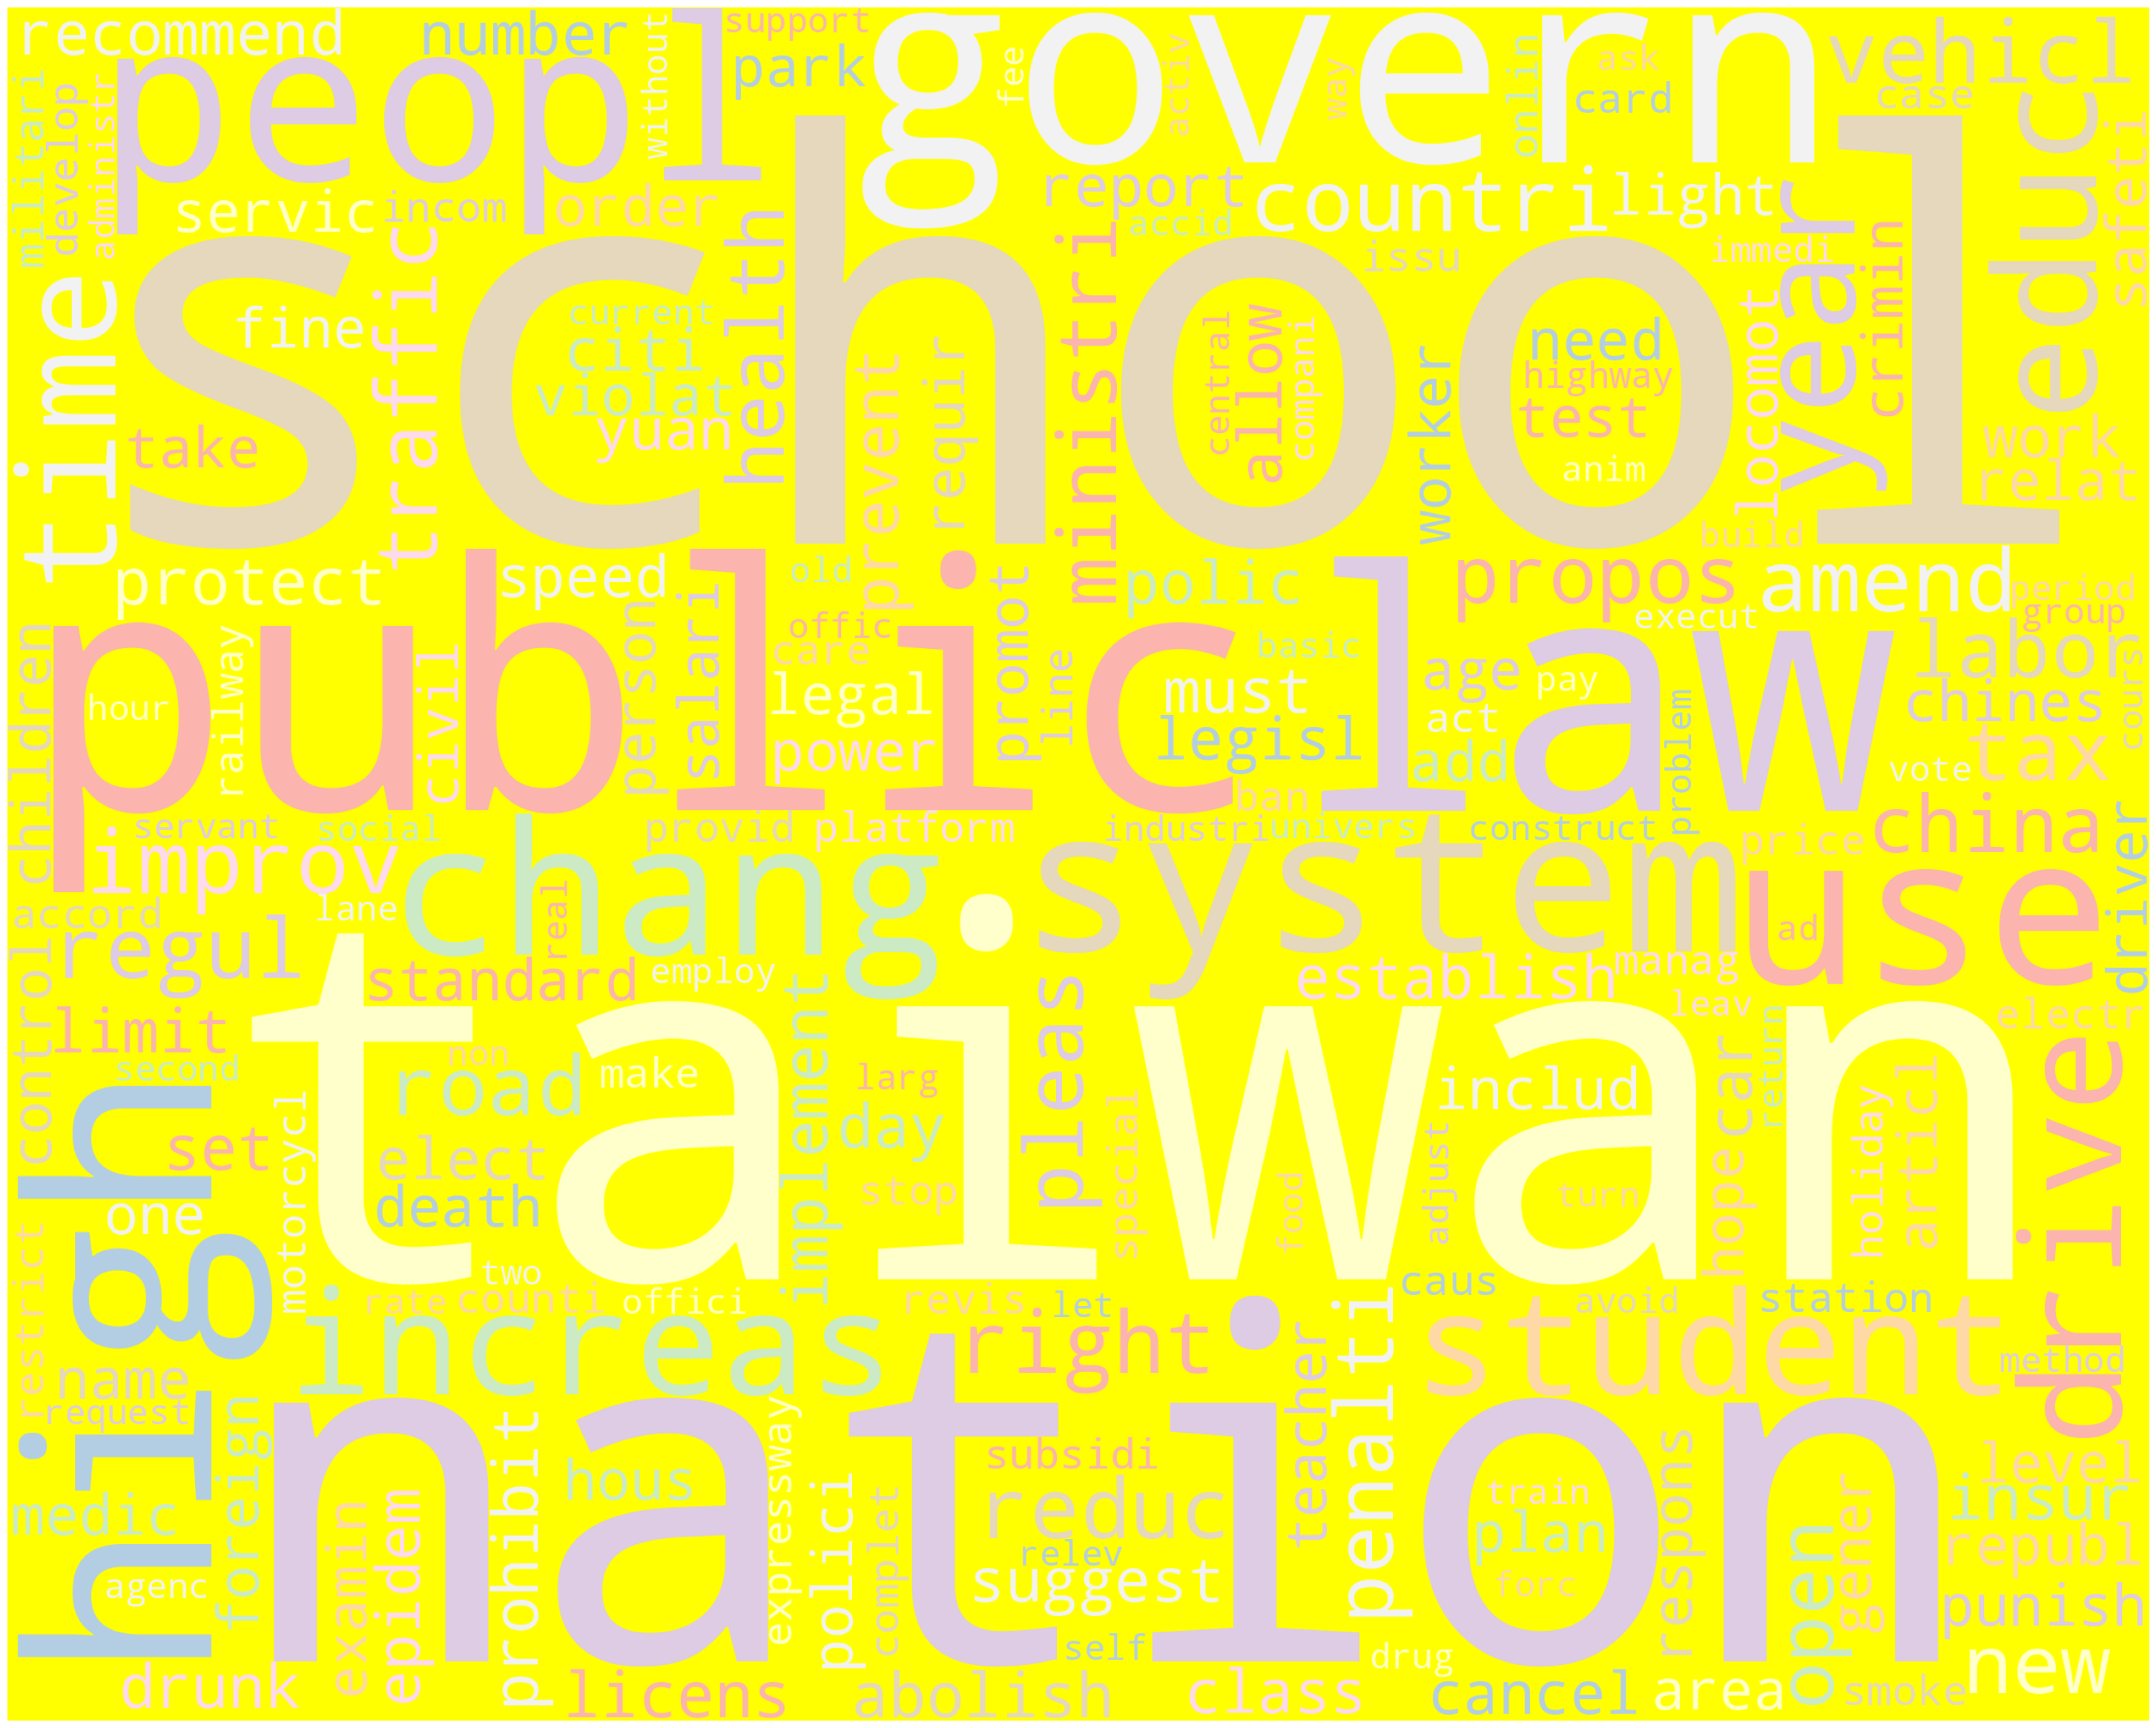

In [200]:
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

wordcloud = WordCloud(width = 2500, height = 2000, random_state=35, background_color='yellow', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(wordcloudinput)
# Plot
plot_cloud(wordcloud)

/home/mojoee/Research/11_UrbanDevelopment/03_UrbanDevelopmentTaiwan/.venv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


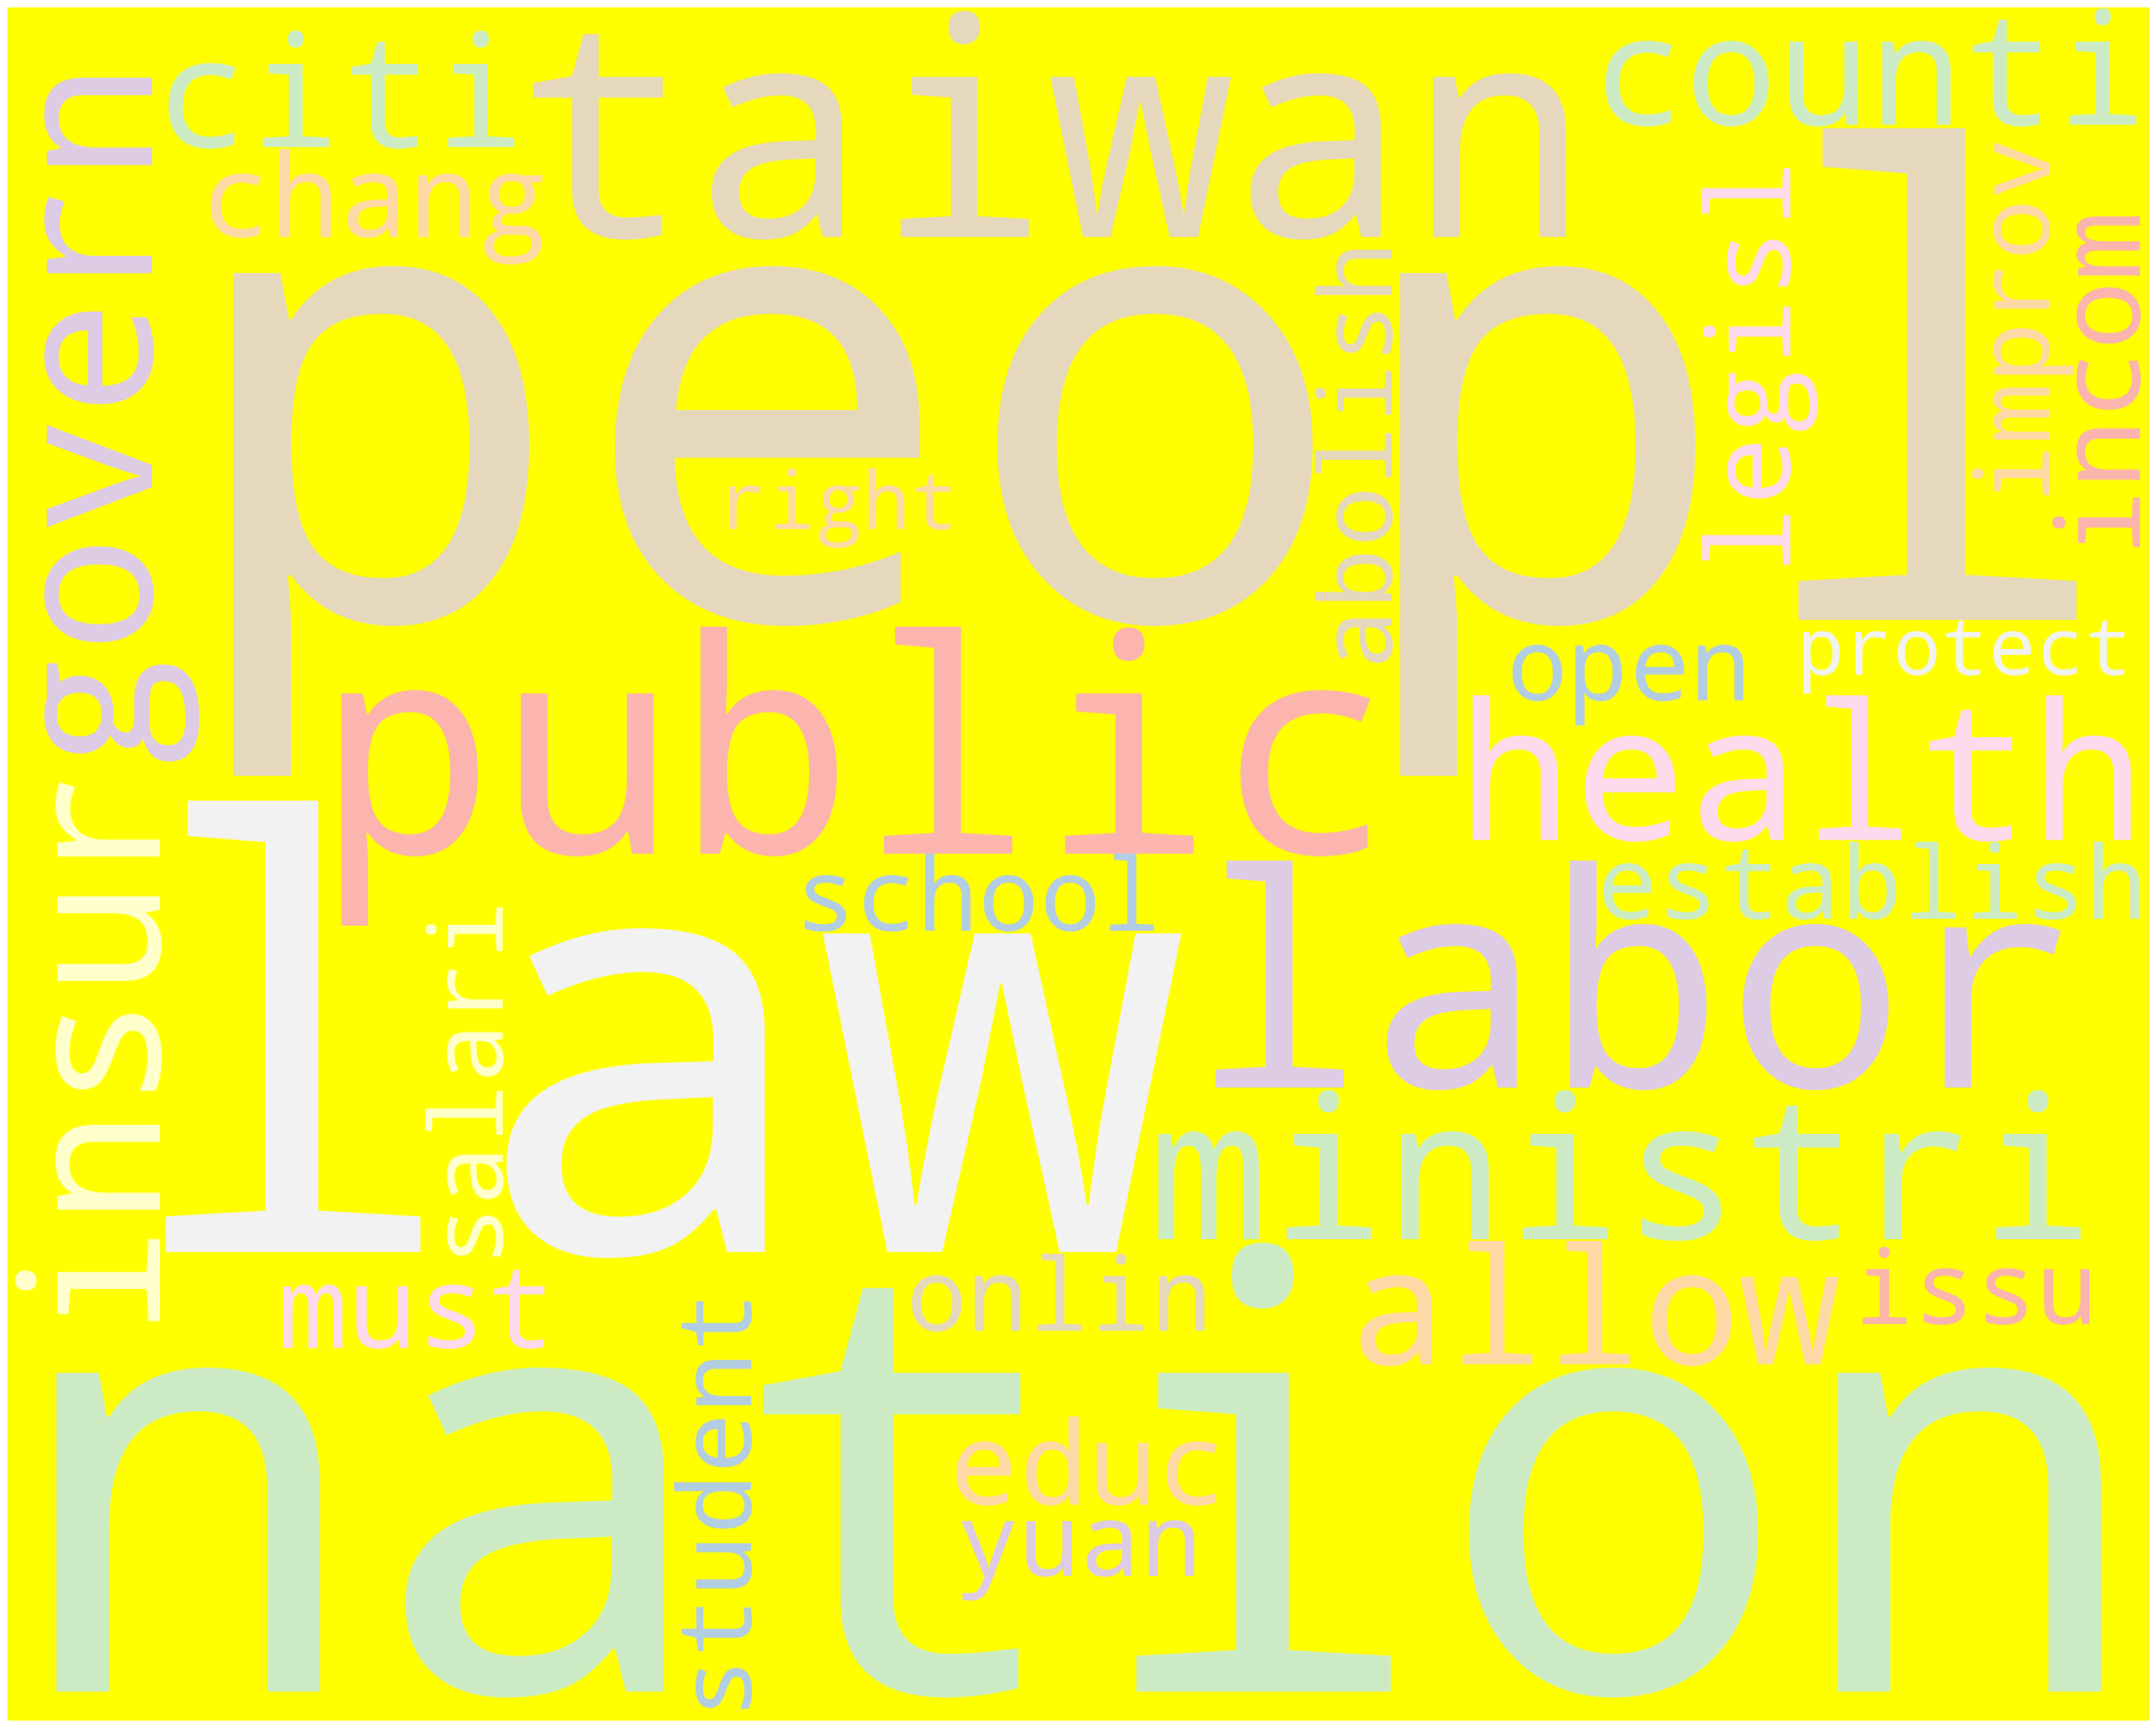

In [204]:
# topic 1

def create_wc_topic(topicID, color, wordN=30):
    #topicID = 0
    inputwordcloud = ""
    top_terms = lda_model.get_topic_terms(topicID, wordN)
    for term in top_terms:
        inputwordcloud += " " + dictionary[term[0]]

    wordcloud = WordCloud(width = 2500, height = 2000, random_state=35, background_color=color, colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(inputwordcloud)
    # Plot
    plot_cloud(wordcloud)

create_wc_topic(0, color="yellow", wordN=30)

/home/mojoee/Research/11_UrbanDevelopment/03_UrbanDevelopmentTaiwan/.venv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


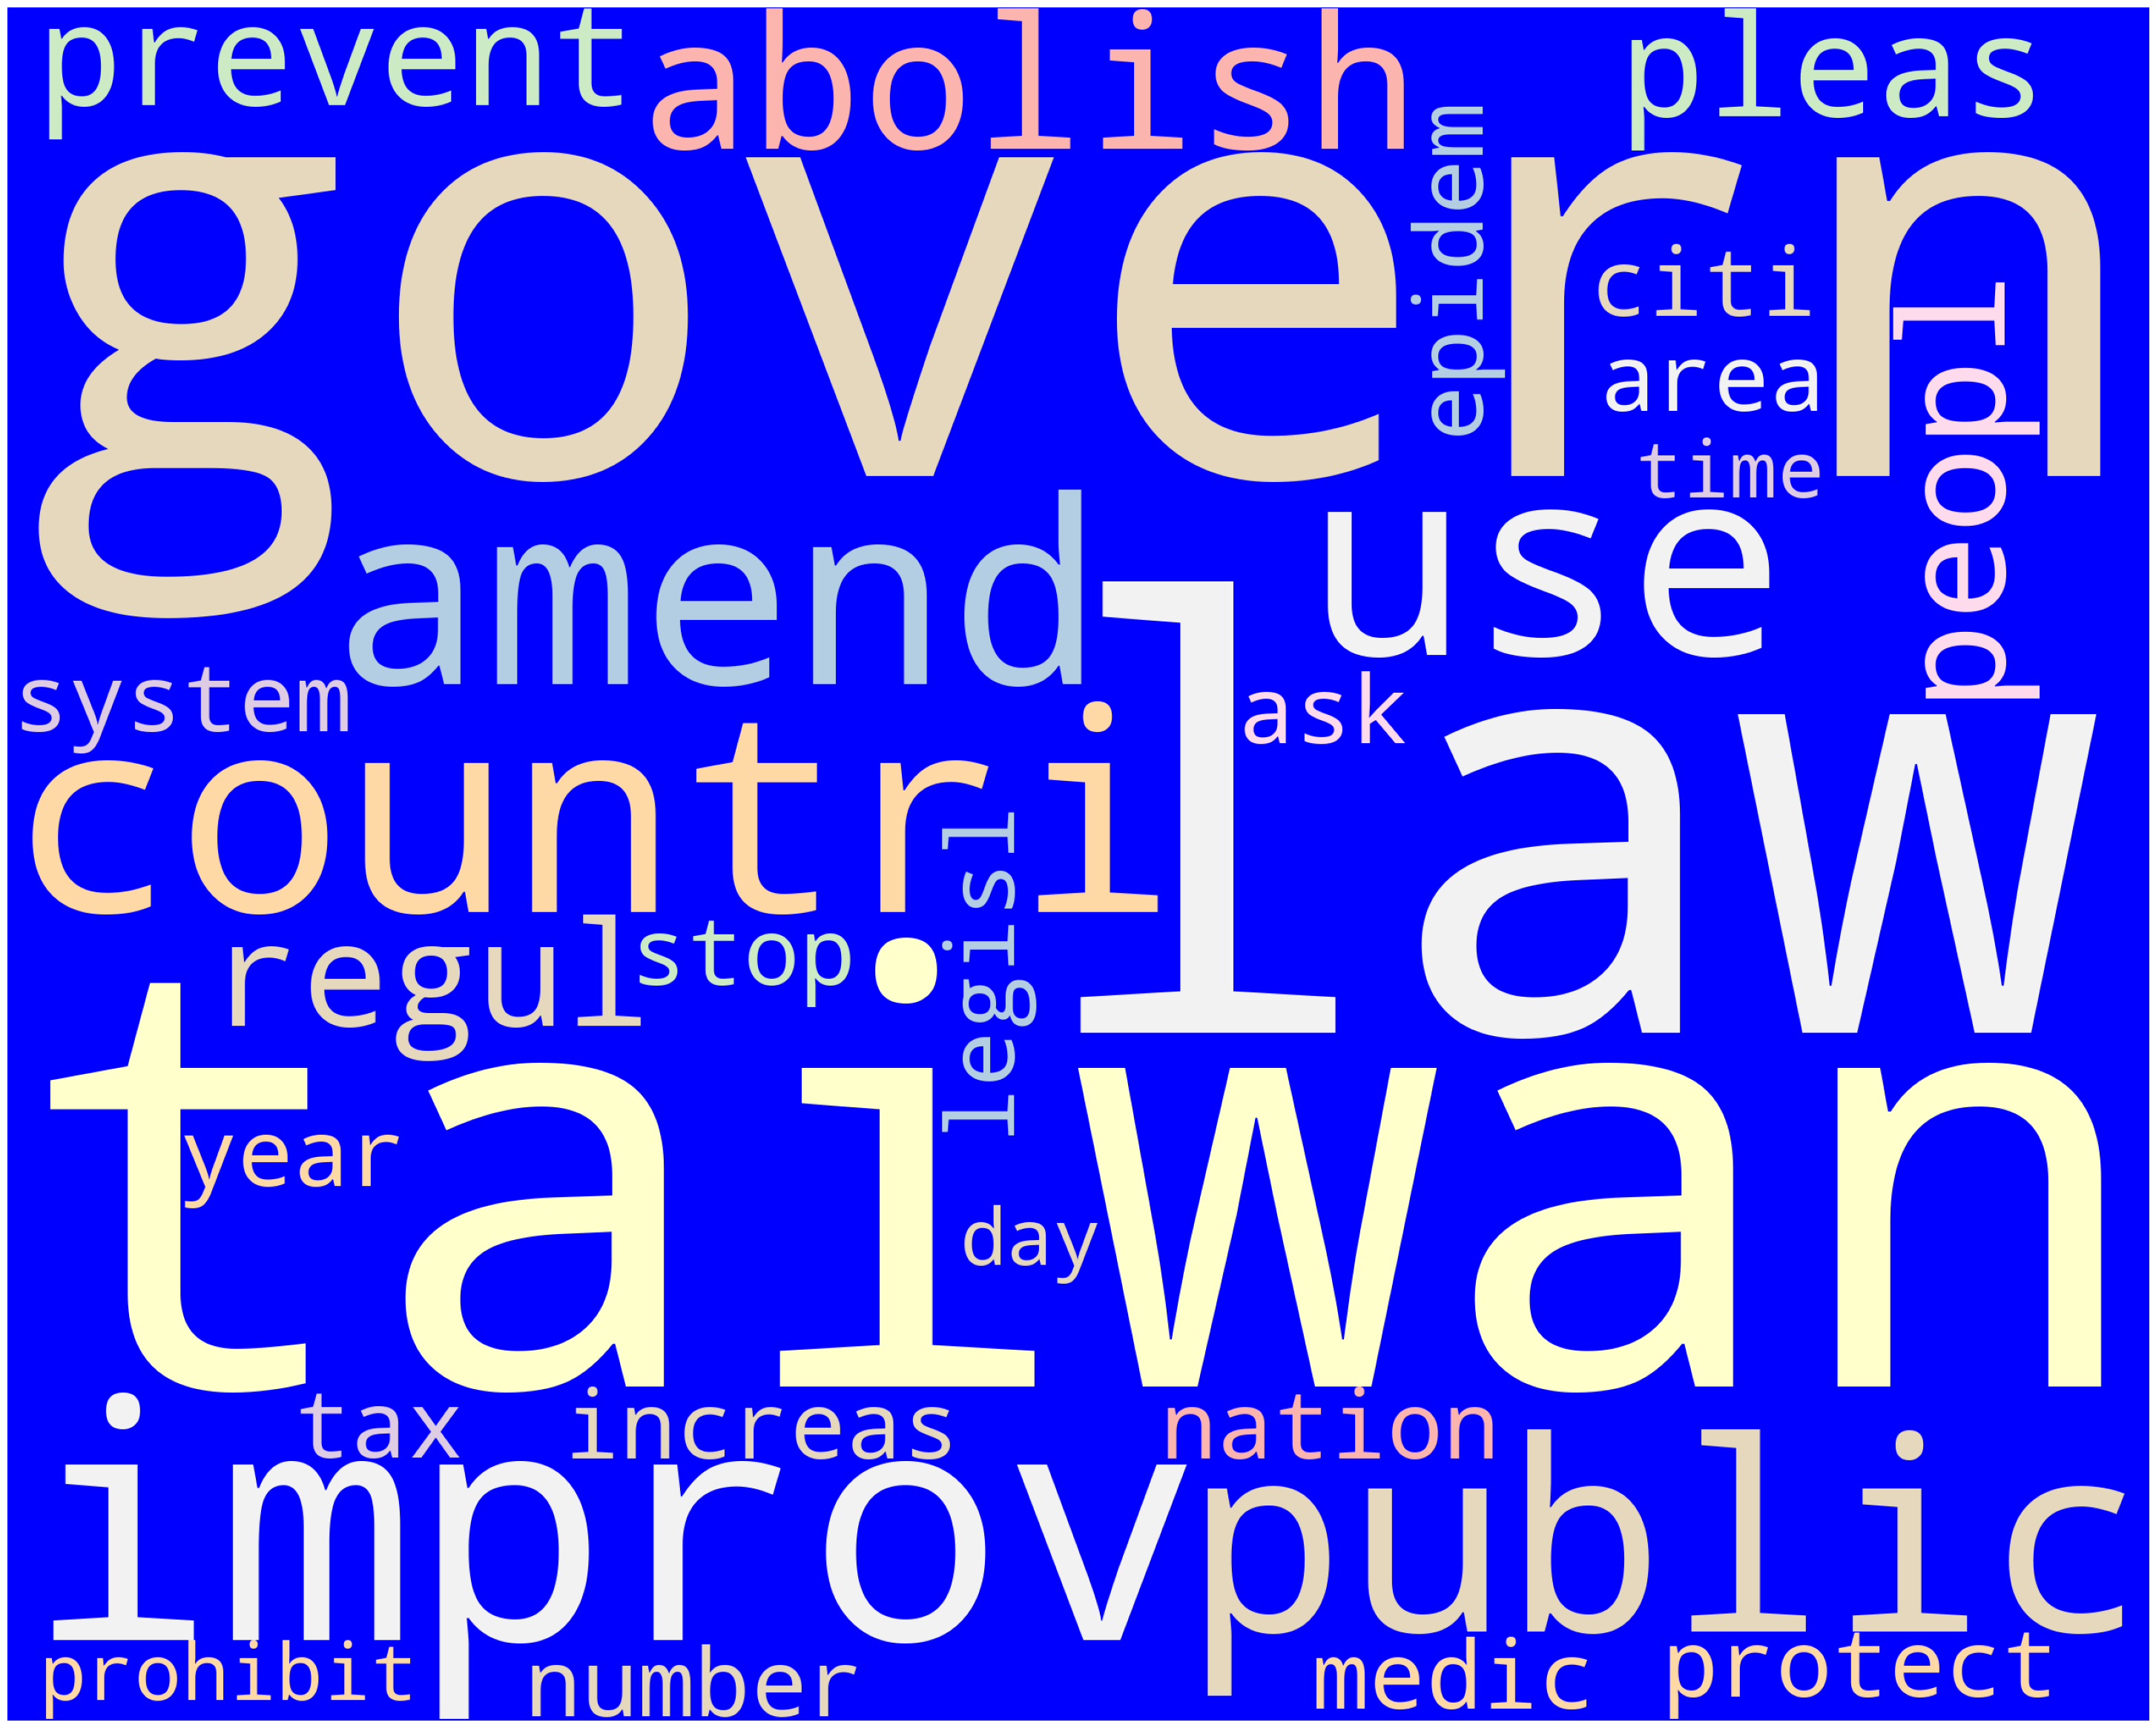

In [207]:
create_wc_topic(1, color="blue", wordN=30)

/home/mojoee/Research/11_UrbanDevelopment/03_UrbanDevelopmentTaiwan/.venv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


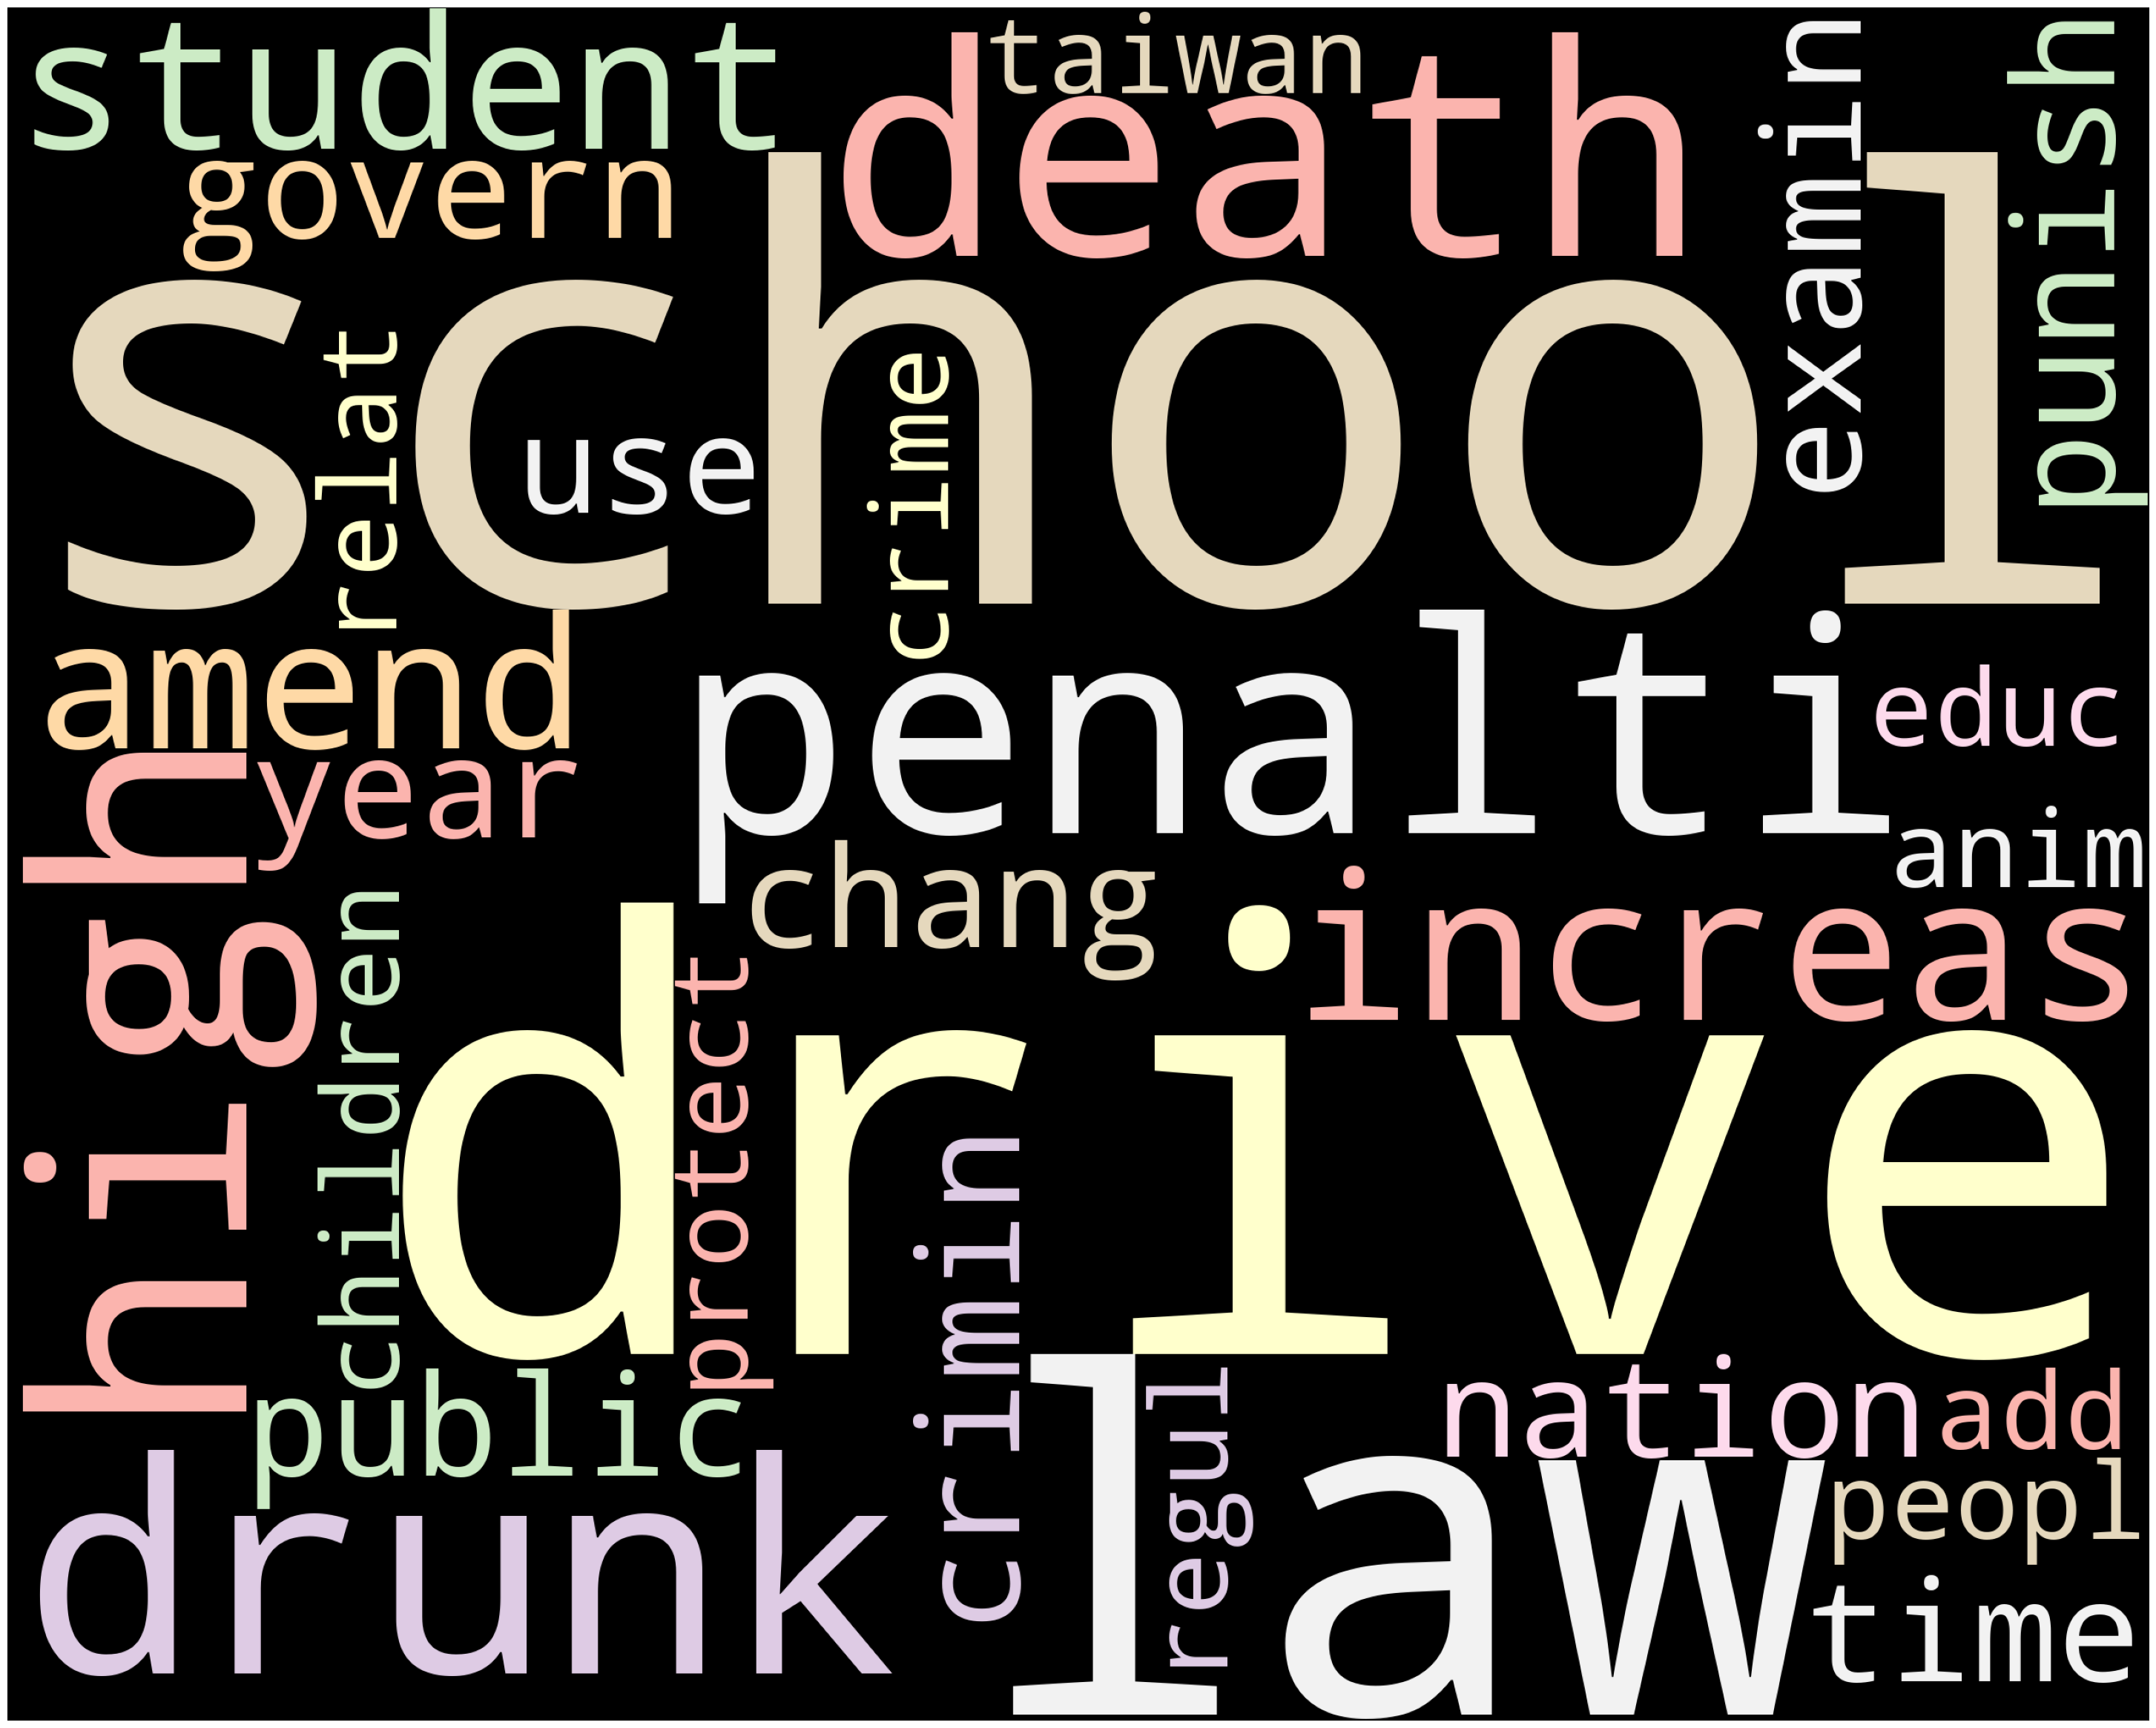

In [208]:
create_wc_topic(2, color="black", wordN=30)

/home/mojoee/Research/11_UrbanDevelopment/03_UrbanDevelopmentTaiwan/.venv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


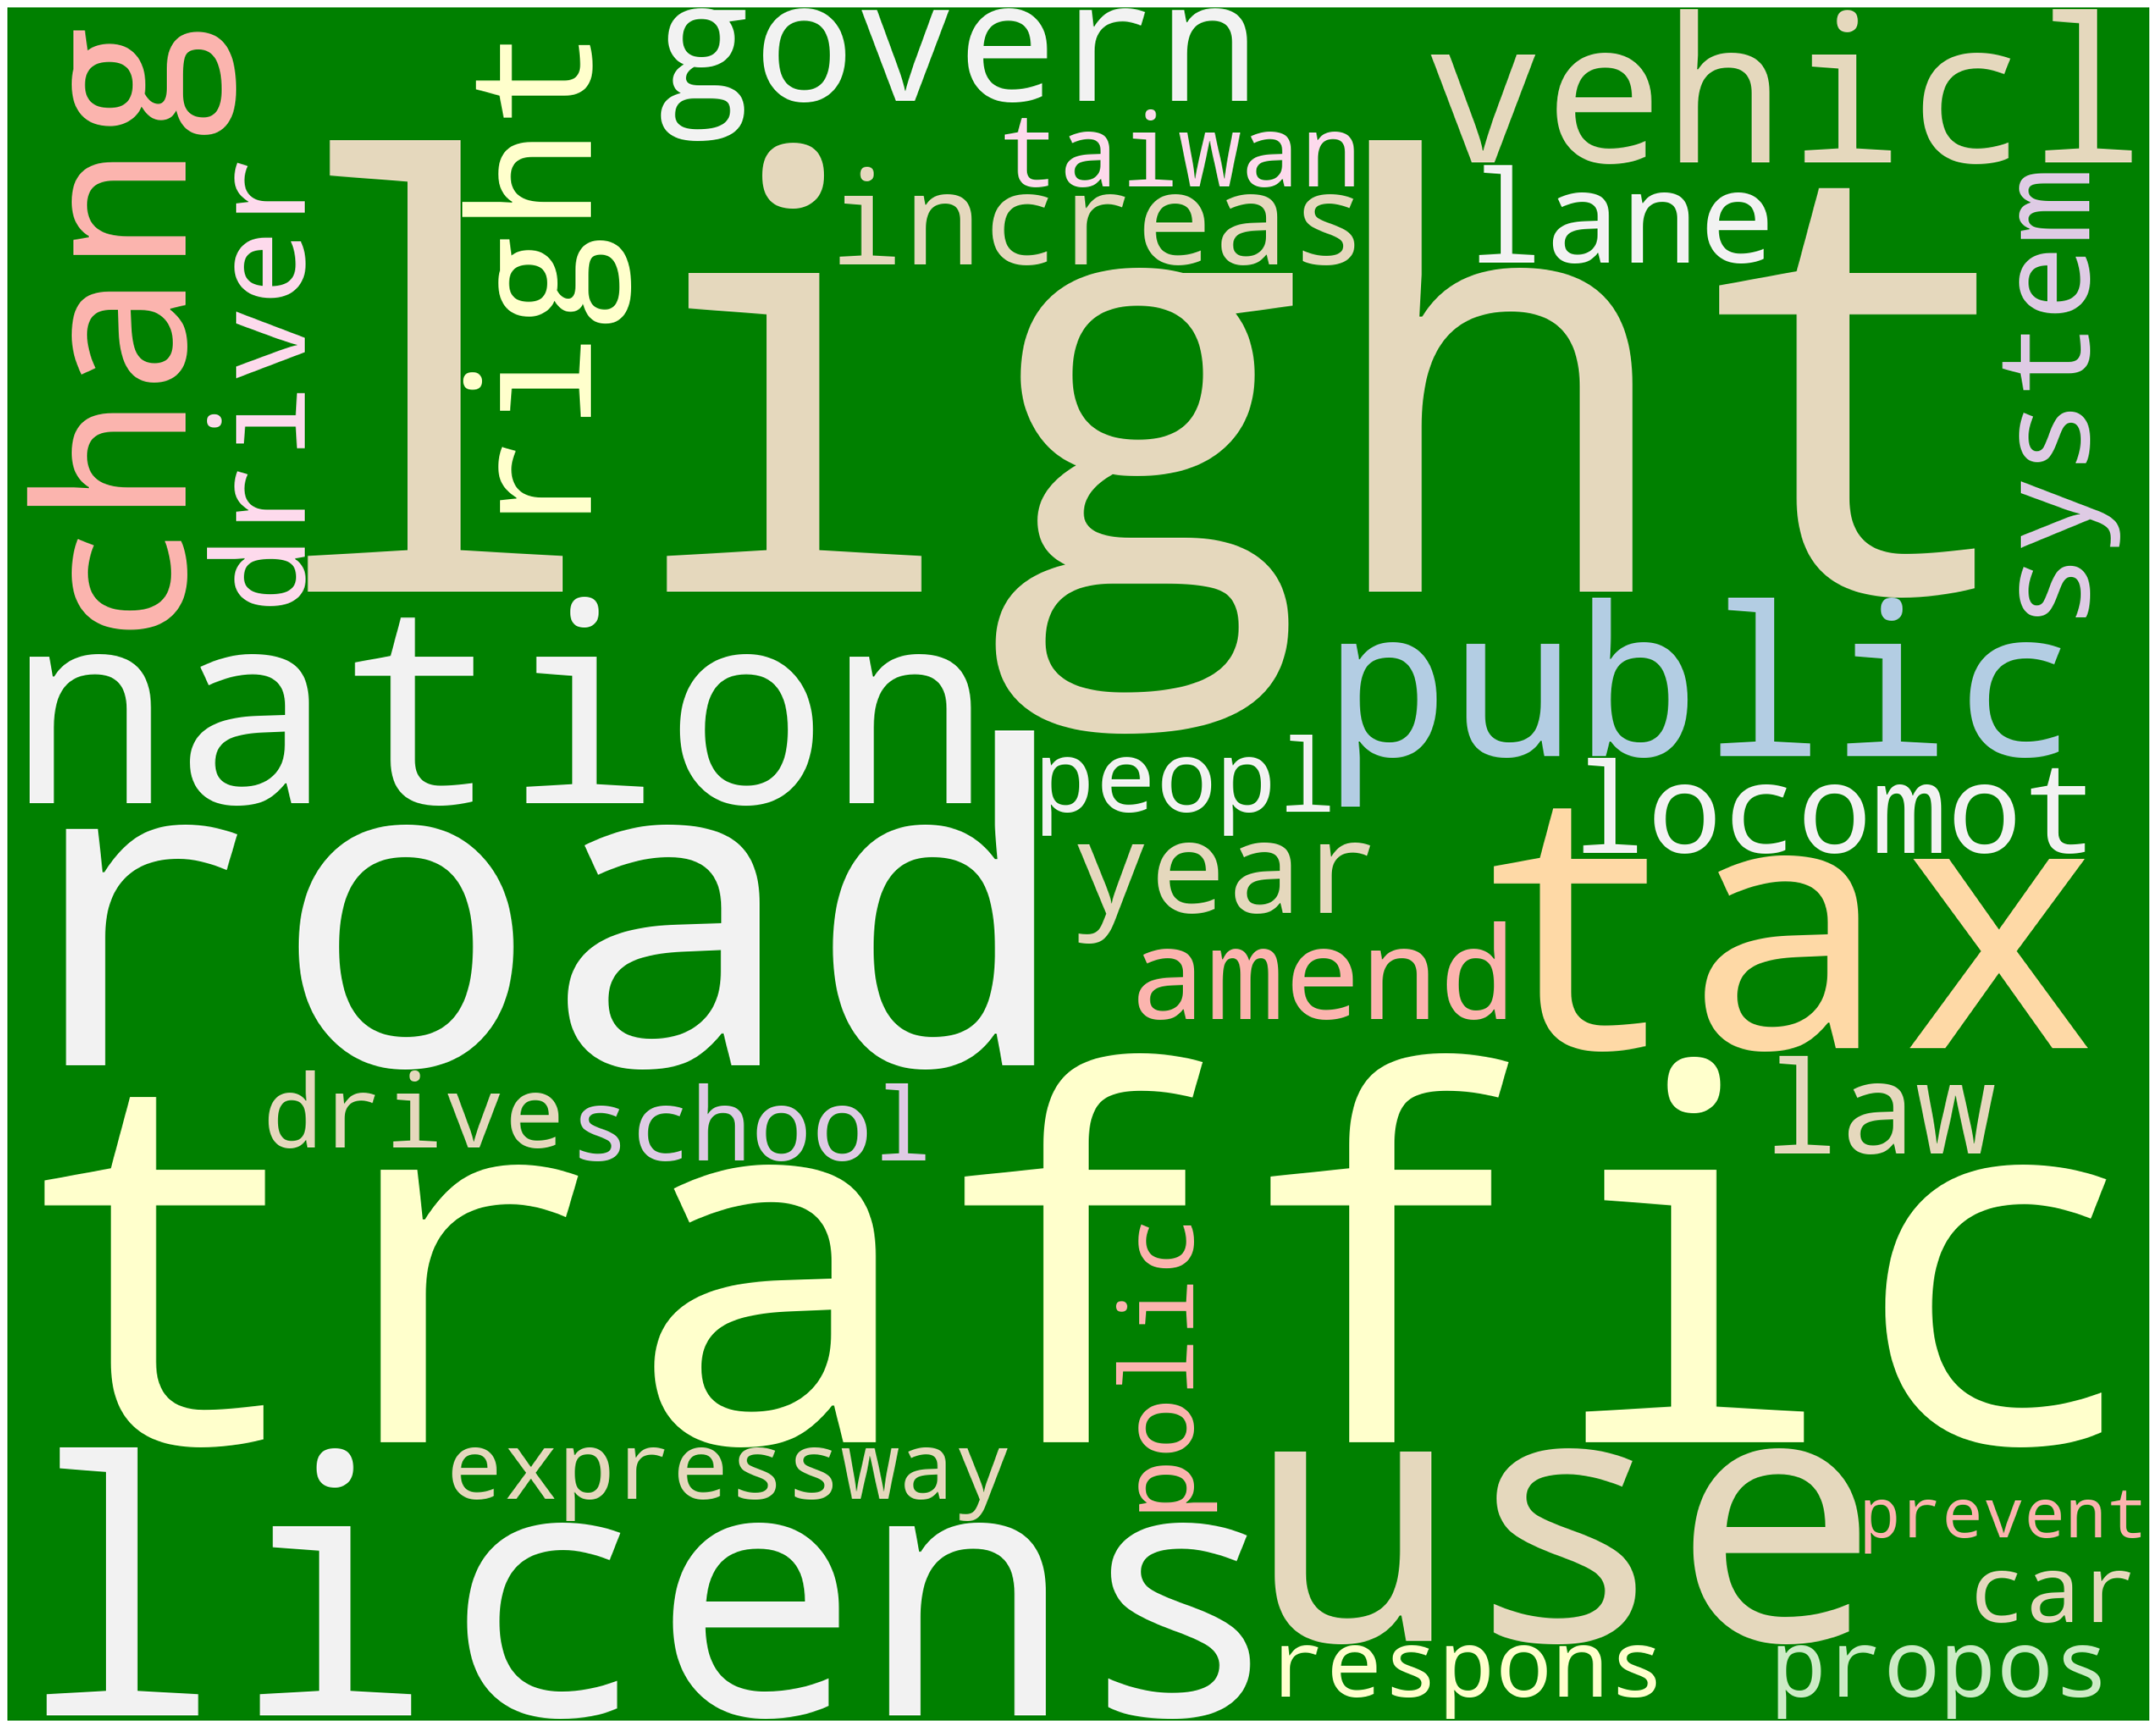

In [209]:
create_wc_topic(3, color="green", wordN=30)

/home/mojoee/Research/11_UrbanDevelopment/03_UrbanDevelopmentTaiwan/.venv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


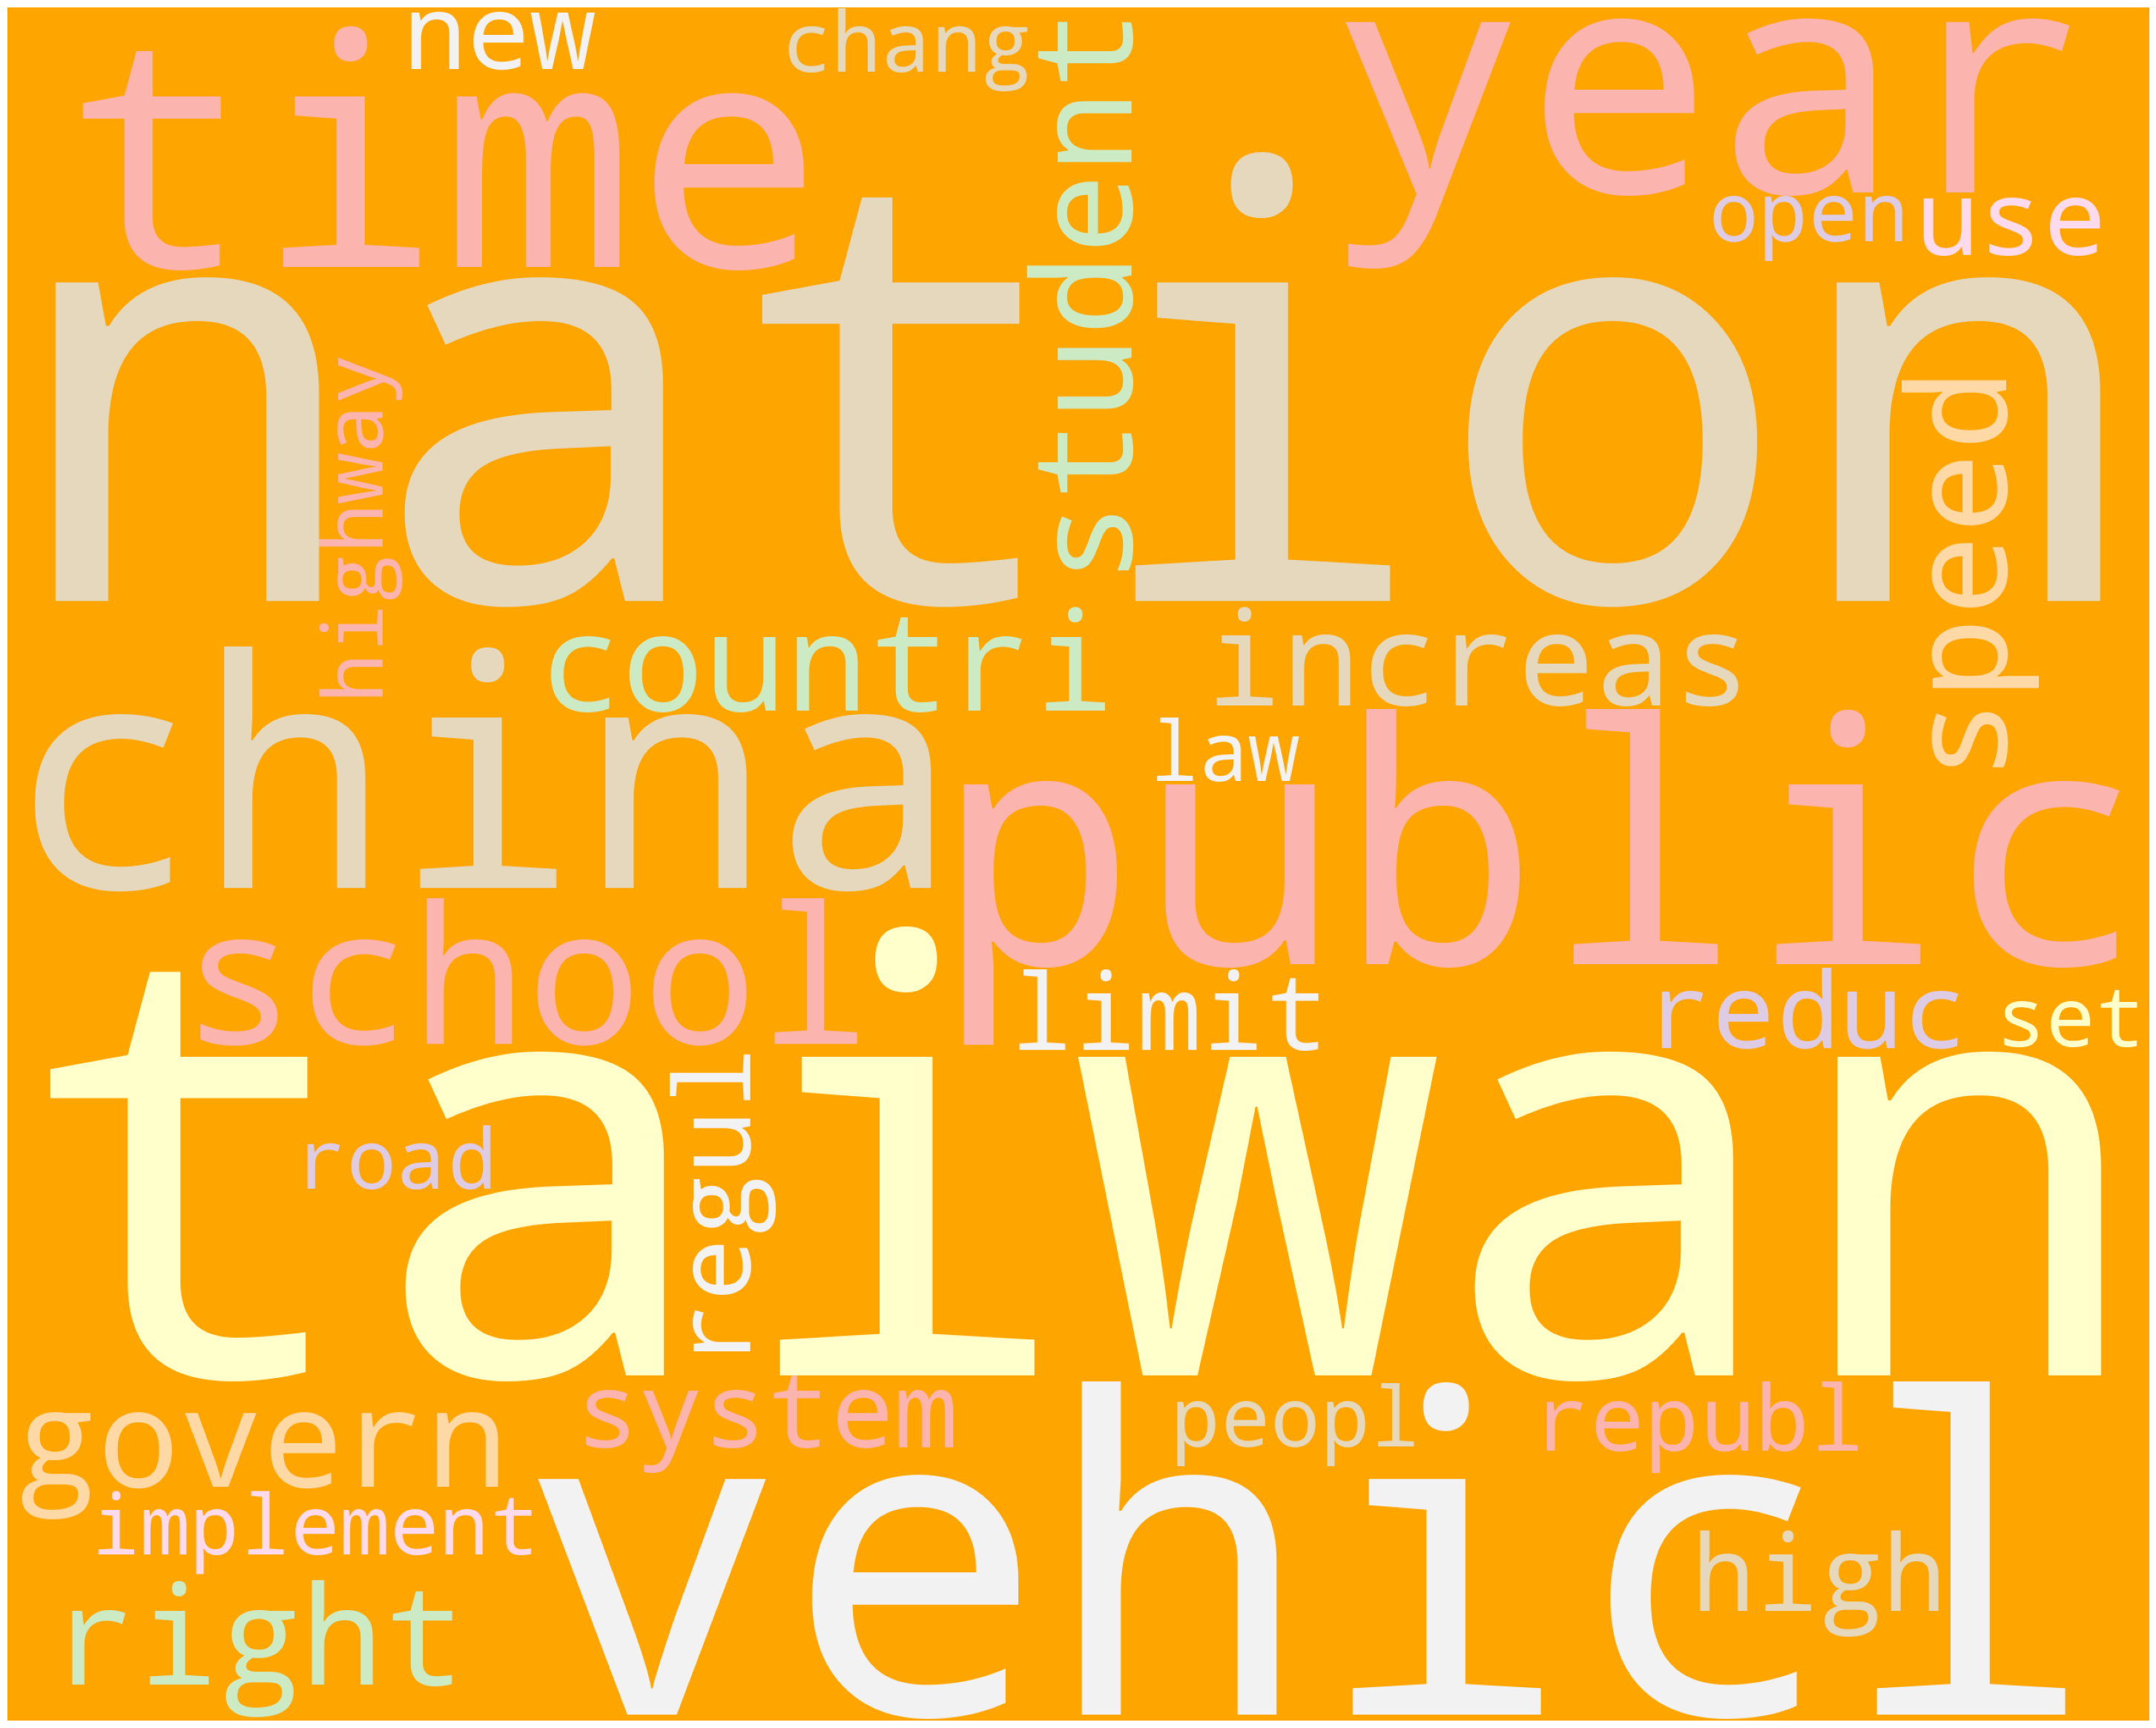

In [210]:
import random
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(num_topics)]
for i in range(num_topics):
    
    create_wc_topic(i, color=colors[i], wordN=30)

In [ ]:
save_data(PassedProposalsTraffic, "./results/PassedProposalsTraffic.csv")
